## Technical Requirements

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')
# plt.rc("figure", figsize=(16, 4))


In [2]:
import sktime
import statsmodels as sm
import matplotlib 
import scipy 

print(f'''
sktime ->  {sktime.__version__}
Matplotlib -> {matplotlib.__version__}
pandas -> {pd.__version__}   
numpy -> {np.__version__}
scipy -> {scipy.__version__}
statsmodels -> {sm.__version__}
''')


sktime ->  0.11.0
Matplotlib -> 3.5.1
pandas -> 1.4.2   
numpy -> 1.21.5
scipy -> 1.7.3
statsmodels -> 0.13.2



In [3]:
###### configurations for image quality#######
plt.rcParams["figure.figsize"] = [14, 5]   ##
# plt.rcParams['figure.dpi'] = 300           ## 300 for printing
plt.rc('font', size=8)                     ## 
plt.rc('axes', titlesize=16)               ## 
plt.rc('axes', labelsize=14)               ##
plt.rc('xtick', labelsize=10)              ##
plt.rc('ytick', labelsize=10)              ##
plt.rc('legend', fontsize=10)              ##
plt.rc('figure', titlesize=12)             ## 
#############################################

In [4]:
def handle_missing_data(df):
    n = int(df.isna().sum())
    if n > 0:
        print(f'found {n} missing observations...')
        df.ffill(inplace=True)

In [5]:
def one_step_forecast(df, window):
    d = df.values
    x = []
    n = len(df)
    idx = df.index[:-window]
    for start in range(n-window):
        end = start + window
        x.append(d[start:end])
    cols = [f'x_{i}' for i in range(1, window+1)]
    x = np.array(x).reshape(n-window, -1)
    y = df.iloc[window:].values
    df_xs = pd.DataFrame(x, columns=cols, index=idx)
    df_y = pd.DataFrame(y.reshape(-1), columns=['y'], index=idx)
    return pd.concat([df_xs, df_y], axis=1).dropna()

In [6]:
def split_data(df, test_split=0.15):
    n = int(len(df) * test_split)
    train, test = df[:-n], df[-n:]
    return train, test

In [7]:
class Standardize:
    def __init__(self, split=0.15):
        self.split = split
    
    def _transform(self, df):
        return (df - self.mu)/self.sigma
    
    def split_data(self, df):
        n = int(len(df) * test_split)
        train, test = df[:-n], df[-n:]
        return train, test
    
    def fit_transform(self, train, test):
        self.mu = train.mean()
        self.sigma = train.std()
        train_s = self._transform(train)
        test_s =  self._transform(test)
        return train_s, test_s

    def transform(self, df):
        return self._transform(df)
    
    def inverse(self, df):
        return (df * self.sigma)+self.mu
        
    def inverse_y(self, df):
        return (df * self.sigma[0])+self.mu[0]

In [8]:
def train_model(train, test, regressor, reg_name):
    X_train, y_train  = train.drop(columns=['y']), train['y']
    X_test, y_test  = test.drop(columns=['y']), test['y']   

    print(f'training {reg_name} ...')
    
    regressor.fit(X_train, y_train) 
     
    yhat = regressor.predict(X_test)    
    rmse_test = np.sqrt(mse(y_test, yhat))
    mape_test = mape(y_test, yhat)
    mase_test = mase(y_test, yhat, y_train=y_train)    
    residuals = y_test.values - yhat     
    
    model_metadata = {
        'Model Name': reg_name, 'Model': regressor, 
        'RMSE': rmse_test, 'MAPE': mape_test, 'MASE': mase_test,
        'yhat': yhat, 'resid': residuals, 'actual': y_test.values}

    return model_metadata

In [9]:
def train_different_models(train, test, regressors):
    results = []
    for reg_name, regressor in regressors.items():
        results.append(train_model(train,
                                   test,
                                   regressor,
                                   reg_name))
    return results

In [10]:
from sktime.performance_metrics.forecasting import(MeanAbsolutePercentageError, 
                                                   MeanSquaredError, 
                                                   MeanAbsoluteScaledError)

mse = MeanSquaredError()
mape = MeanAbsolutePercentageError()
mase = MeanAbsoluteScaledError()

**Check core library versions used in the recipe**
* if using **Colab** ensure the versions are the same. If needed to update use
```shell
!pip install <library_name> -U
```

In [11]:
path = Path('../../datasets/Ch12/')
# Read the daily_weather.csv 

daily_weather = pd.read_csv(path.joinpath('daily_weather.csv'), 
                      index_col='DateTime', 
                      parse_dates=True)
daily_weather.columns = ['y']
energy = pd.read_csv(path.joinpath('energy_consumption.csv'), 
                     index_col='Month', 
                     parse_dates=True)
energy.columns = ['y']

air = pd.read_csv(path.joinpath('air_passenger.csv'), 
                  index_col='date', 
                  parse_dates=True)
air.columns = ['y']

In [12]:
daily_weather.index.freq = 'D'
energy.index.freq = 'MS'
air.index.freq = 'M'

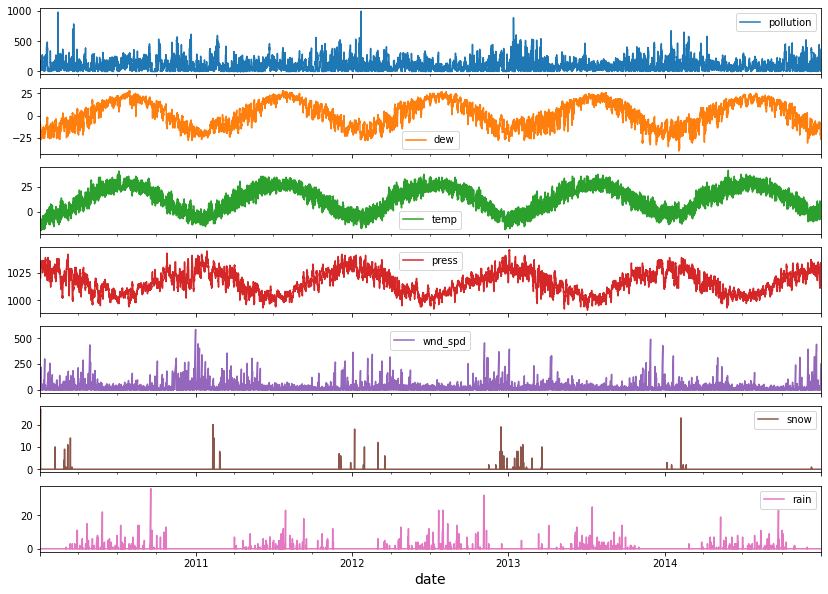

In [6]:
pollution = pd.read_csv(path.joinpath('air_pollution.csv'), index_col='date', parse_dates=True, infer_datetime_format=True)
pollution.plot(subplots=True, figsize=(14, 10));

In [13]:
print(daily_weather.index.freq)
print(energy.index.freq)
print(air.index.freq)

<Day>
<MonthBegin>
<MonthEnd>


<AxesSubplot:title={'center':'Monthly Passengers'}, xlabel='date'>

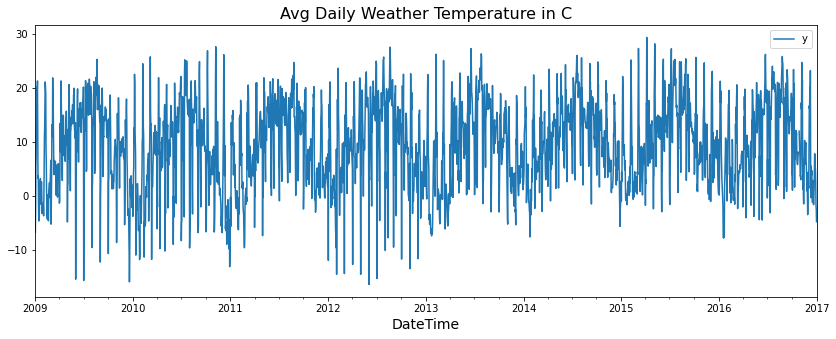

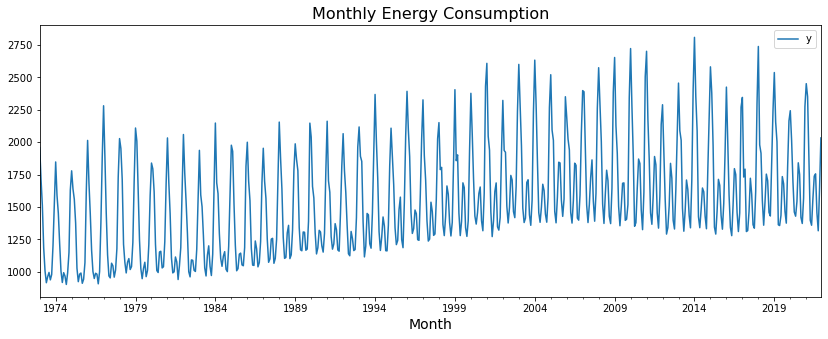

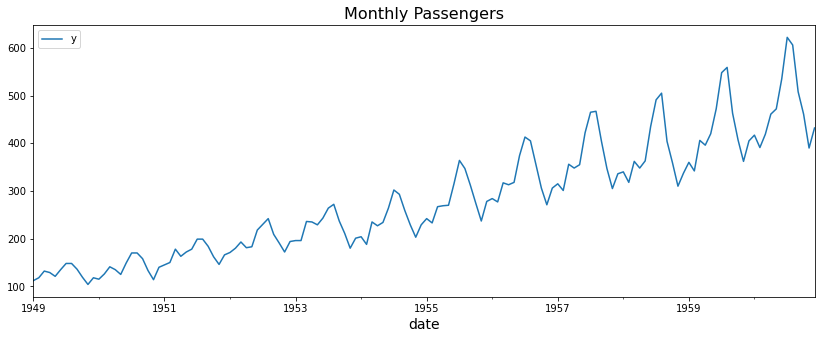

In [8]:
daily_weather.plot(title='Avg Daily Weather Temperature in C')
energy.plot(title='Monthly Energy Consumption')
air.plot(title='Monthly Passengers')

# Preparing Time Series for Supervised Machine Learning

In [45]:
air_copy = air.copy()
energy_copy = energy.copy()
daily_weather_copy = daily_weather.copy()

In [46]:
def handle_missing_data(df):
    n = int(df.isna().sum())
    if n > 0:
        print(f'found {n} missing observations...')
        df.ffill(inplace=True)

In [47]:
for df in [air_copy, energy_copy, daily_weather_copy]:
    handle_missing_data(df)

found 2 missing observations...


In [48]:
daily_weather_copy.isna().sum()

y    0
dtype: int64

In [49]:
def one_step_forecast(df, window):
    d = df.values
    x = []
    n = len(df)
    idx = df.index[:-window]
    for start in range(n-window):
        end = start + window
        x.append(d[start:end])
    cols = [f'x_{i}' for i in range(1, window+1)]
    x = np.array(x).reshape(n-window, -1)
    y = df.iloc[window:].values
    df_xs = pd.DataFrame(x, columns=cols, index=idx)
    df_y = pd.DataFrame(y.reshape(-1), columns=['y'], index=idx)
    return pd.concat([df_xs, df_y], axis=1).dropna()

In [50]:
air_os = one_step_forecast(air_copy, 5)
energy_os = one_step_forecast(energy_copy, 5)
daily_weather_os = one_step_forecast(daily_weather_copy, 5)
print(air_os.shape)
print(energy_os.shape)
print(daily_weather_os.shape)

(139, 6)
(583, 6)
(2918, 6)


In [51]:
air_os.head()

x_1  x_2  x_3  x_4  x_5    y
date                                    
1949-01-31  112  118  132  129  121  135
1949-02-28  118  132  129  121  135  148
1949-03-31  132  129  121  135  148  148
1949-04-30  129  121  135  148  148  136
1949-05-31  121  135  148  148  136  119

In [52]:
def split_data(df, test_split=0.15):
    n = int(len(df) * test_split)
    train, test = df[:-n], df[-n:]
    return train, test

In [53]:
train, test = split_data(air_os)
print(f'Train: {len(train)} Test: {len(test)}')

Train: 119 Test: 20


In [54]:
class Standardize:
    def __init__(self, split=0.15):
        self.split = split
    
    def _transform(self, df):
        return (df - self.mu)/self.sigma
    
    def split_data(self, df):
        n = int(len(df) * test_split)
        train, test = df[:-n], df[-n:]
        return train, test
    
    def fit_transform(self, train, test):
        self.mu = train.mean()
        self.sigma = train.std()
        train_s = self._transform(train)
        test_s =  self._transform(test)
        return train_s, test_s

    def transform(self, df):
        return self._transform(df)
    
    def inverse(self, df):
        return (df * self.sigma)+self.mu
        
    def inverse_y(self, df):
        return (df * self.sigma[0])+self.mu[0]

In [61]:
scaler = Standardize()
train, test = scaler.fit_transform(train, test)
train.head()

x_1       x_2       x_3       x_4       x_5         y
date                                                                  
1949-01-31 -1.401933 -1.364908 -1.240908 -1.294771 -1.398791 -1.273682
1949-02-28 -1.338755 -1.216817 -1.272708 -1.379791 -1.250613 -1.136238
1949-03-31 -1.191342 -1.248551 -1.357508 -1.231006 -1.113020 -1.136238
1949-04-30 -1.222930 -1.333174 -1.209108 -1.092848 -1.113020 -1.263109
1949-05-31 -1.307167 -1.185083 -1.071309 -1.092848 -1.240029 -1.442843

In [57]:
y_train_original = scaler.inverse_y(train['y'])

In [60]:
train_original = scaler.inverse(train)
train_original.head()

x_1    x_2    x_3    x_4    x_5      y
date                                                
1949-01-31  112.0  118.0  132.0  129.0  121.0  135.0
1949-02-28  118.0  132.0  129.0  121.0  135.0  148.0
1949-03-31  132.0  129.0  121.0  135.0  148.0  148.0
1949-04-30  129.0  121.0  135.0  148.0  148.0  136.0
1949-05-31  121.0  135.0  148.0  148.0  136.0  119.0

## There is more

In [11]:
class Stationrize:
    def __init__(self):
        pass
    
    def check_stationarity(self, data):
        if adfuller(data)[1] < 0.05:
            self.status = "Stationary"
        else:
            self.status = "Non Stationary"
        return self.status
            
    def transform(self, df, order=1):
        status = self.check_stationarity(df)
        if status != 'Stationary':
            self.shifted = df.shift(periods=order)
            return (df - self.shifted).dropna()
        else:
            return df
    
    def inverse(self, df):
        return df + self.shifted


# Forecasting using Linear Regression Models with Scikit-Learn

## How to do it..

In [112]:
from sklearn.linear_model import( LinearRegression, 
                                 ElasticNet, 
                                 Ridge, 
                                 Lasso, 
                                 HuberRegressor)

In [113]:
air_cp = air.copy()
en_cp = energy.copy()
dw_cp = daily_weather.copy()

### Preprocessing Time Series Data

In [114]:
for df in [air_cp, en_cp, dw_cp]:
    handle_missing_data(df)

found 2 missing observations...


In [115]:
air_reg = one_step_forecast(air_cp, 10)
en_reg = one_step_forecast(en_cp, 10)
dw_reg = one_step_forecast(dw_cp, 10)

In [116]:
print(air_reg.shape)
print(en_reg.shape)
print(dw_reg.shape)

(134, 11)
(578, 11)
(2913, 11)


In [117]:
mse = MeanSquaredError()
mape = MeanAbsolutePercentageError()
mase = MeanAbsoluteScaledError()

In [66]:
train_air, test_air = split_data(air_reg, test_split=0.10)
scaler_air = Standardize()
train_air_s, test_air_s = scaler_air.fit_transform(train_air,test_air)

In [67]:
train_en, test_en = split_data(en_reg, test_split=0.10)
scaler_en = Standardize()
train_en_s, test_en_s = scaler_en.fit_transform(train_en, test_en)

In [68]:
train_dw, test_dw = split_data(dw_reg, test_split=0.10)
scaler_dw = Standardize()
train_dw_s, test_dw_s = scaler_dw.fit_transform(train_dw,test_dw)

### Train

In [118]:
def train_model(train, test, regressor, reg_name):
    X_train, y_train  = train.drop(columns=['y']), train['y']
    X_test, y_test  = test.drop(columns=['y']), test['y']   

    print(f'training {reg_name} ...')
    
    regressor.fit(X_train, y_train) 
     
    yhat = regressor.predict(X_test)    
    rmse_test = np.sqrt(mse(y_test, yhat))
    mape_test = mape(y_test, yhat)
    mase_test = mase(y_test, yhat, y_train=y_train)    
    residuals = y_test.values - yhat     
    
    model_metadata = {
        'Model Name': reg_name, 'Model': regressor, 
        'RMSE': rmse_test, 'MAPE': mape_test, 'MASE': mase_test,
        'yhat': yhat, 'resid': residuals, 'actual': y_test.values}

    return model_metadata

In [119]:
regressors = {
    'Linear Regression': LinearRegression(fit_intercept=False),
    'Elastic Net': ElasticNet(0.5, fit_intercept=False),
    'Ridge Regression': Ridge(0.5, fit_intercept=False),
    'Lasso Regression': Lasso(0.5, fit_intercept=False),
    'Huber Regression': HuberRegressor(fit_intercept=False)}

In [120]:
def train_different_models(train, test, regressors):
    results = []
    for reg_name, regressor in regressors.items():
        results.append(train_model(train,
                                   test,
                                   regressor,
                                   reg_name))
    return results

In [146]:
air_results = train_different_models(train_air_s, test_air_s, regressors)
en_results = train_different_models(train_en_s, test_en_s, regressors)
dw_results = train_different_models(train_dw_s, test_dw_s, regressors)

training Linear Regression ...
training Elastic Net ...
training Ridge Regression ...
training Lasso Regression ...
training Huber Regression ...
training Linear Regression ...
training Elastic Net ...
training Ridge Regression ...
training Lasso Regression ...
training Huber Regression ...
training Linear Regression ...
training Elastic Net ...
training Ridge Regression ...
training Lasso Regression ...
training Huber Regression ...


### Evaluate

In [147]:
cols = ['Model Name', 'RMSE', 'MAPE', 'MASE']
air_results = pd.DataFrame(air_results)
air_results[cols].sort_values('MASE')

Model Name      RMSE      MAPE      MASE
2   Ridge Regression  0.381092  0.210168  1.390807
0  Linear Regression  0.385559  0.213810  1.411072
4   Huber Regression  0.400949  0.226859  1.457932
1        Elastic Net  0.829023  0.406390  2.808737
3   Lasso Regression  1.190006  0.780255  4.439302

In [148]:
cols = ['Model Name', 'RMSE', 'MAPE', 'MASE']
en_results = pd.DataFrame(en_results)
en_results[cols].sort_values('MASE')

Model Name      RMSE      MAPE      MASE
4   Huber Regression  0.431651  0.729910  0.525526
2   Ridge Regression  0.433192  0.819432  0.560450
0  Linear Regression  0.433747  0.818459  0.560989
1        Elastic Net  0.747657  1.398025  1.013425
3   Lasso Regression  0.834356  1.502494  1.108092

In [149]:
cols = ['Model Name', 'RMSE', 'MAPE', 'MASE']
dw_results = pd.DataFrame(dw_results)
dw_results[cols].sort_values('MASE')

Model Name      RMSE      MAPE      MASE
4   Huber Regression  0.655729  0.697774  0.968735
0  Linear Regression  0.646648  0.735055  0.990057
2   Ridge Regression  0.646639  0.735072  0.990085
1        Elastic Net  0.737896  1.075669  1.300792
3   Lasso Regression  0.814609  1.304278  1.468567

In [125]:
from statsmodels.graphics.tsaplots import plot_acf
def plot_results(cols, results, data_name):
    for row in results[cols].iterrows():
        yhat, resid, actual, name = row[1]
        plt.title(f'{data_name} - {name}')
        plt.plot(actual, 'k--', alpha=0.5)
        plt.plot(yhat, 'k')
        plt.legend(['actual', 'forecast'])
        plot_acf(resid, zero=False, 
                 title=f'{data_name} - Autocorrelation')
        plt.show()

#### Air Passengers Plots

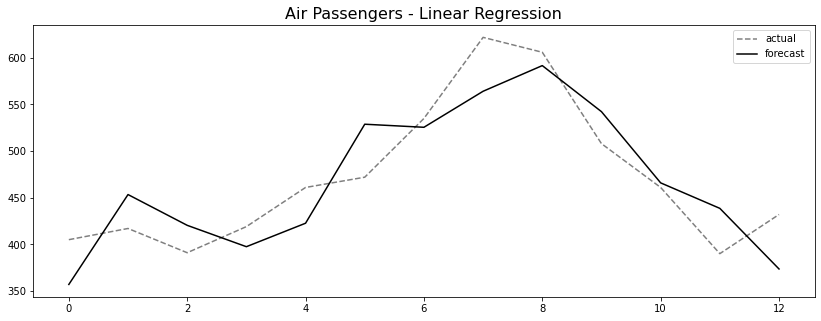

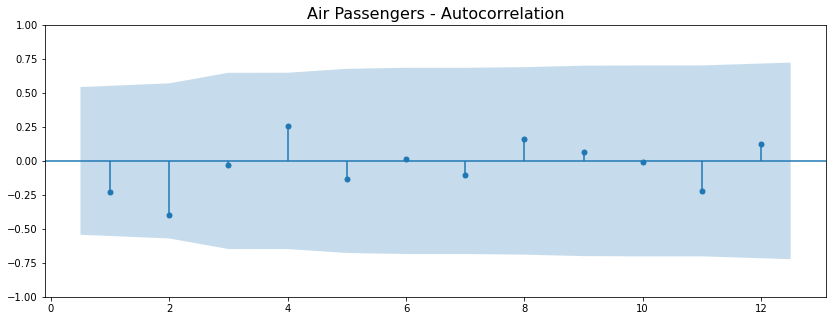

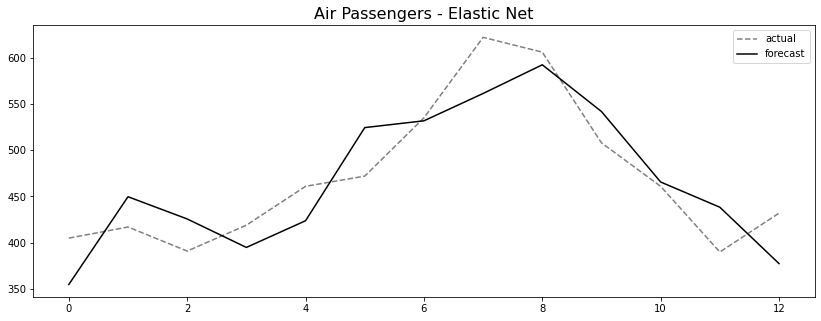

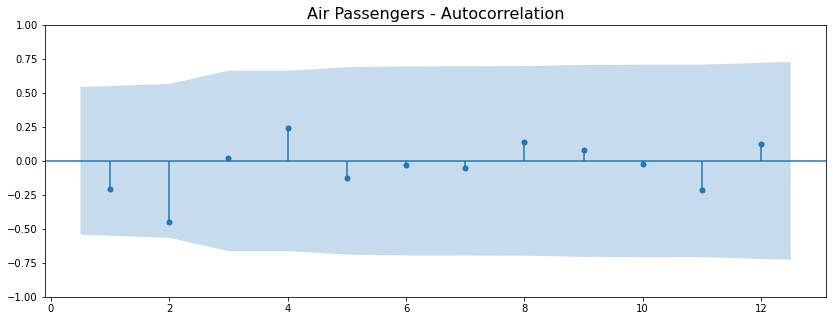

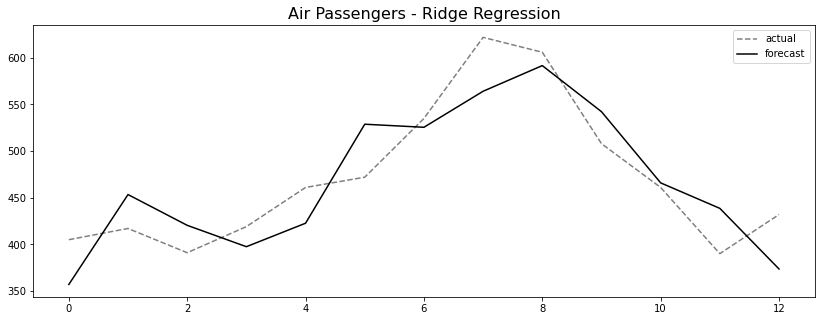

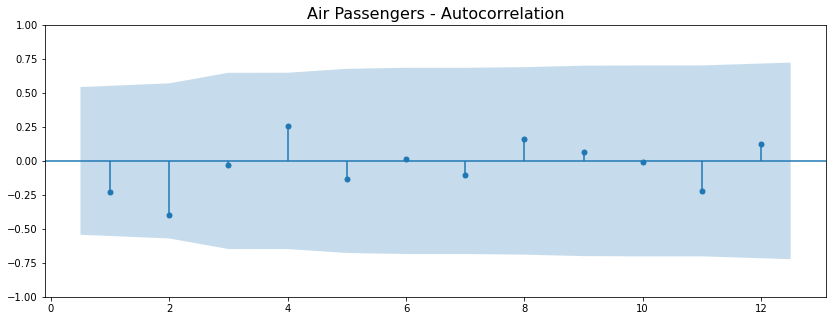

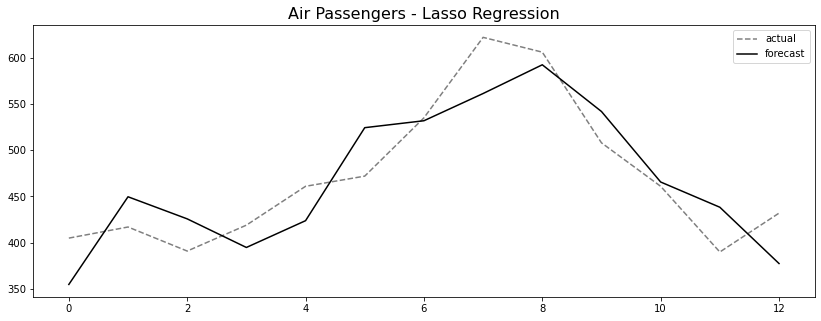

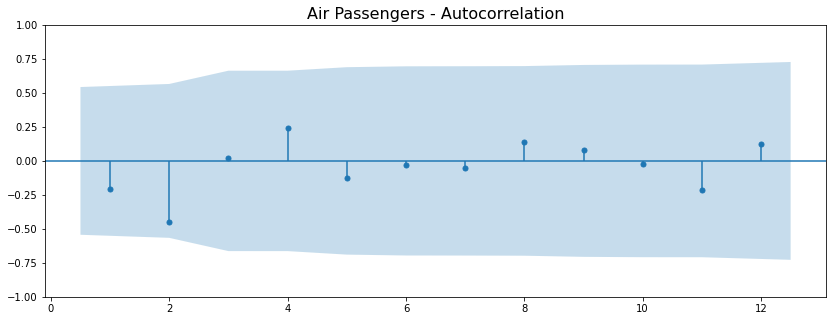

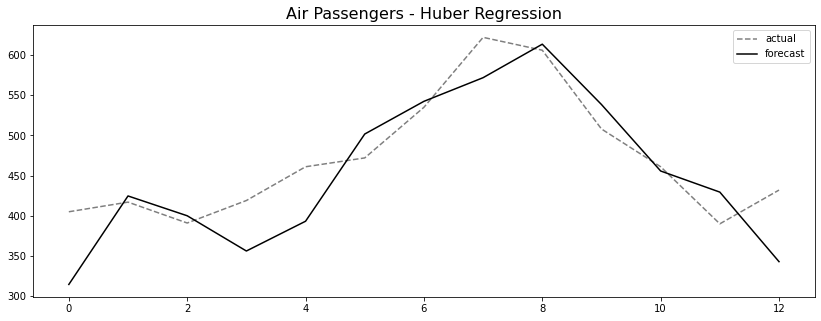

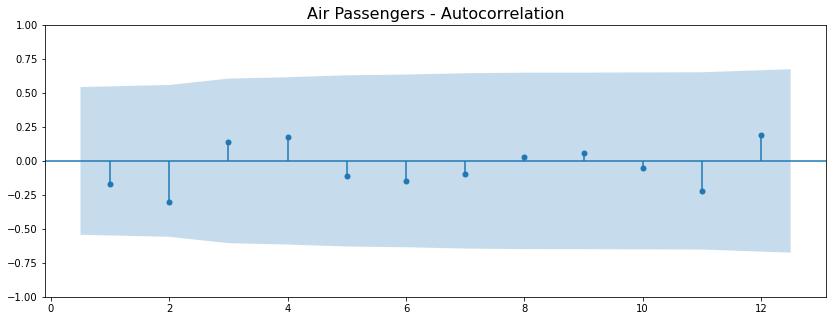

In [126]:
cols = ['yhat', 'resid', 'actual', 'Model Name']
plot_results(cols, air_results, 'Air Passengers')


#### Energy Consumption Plots

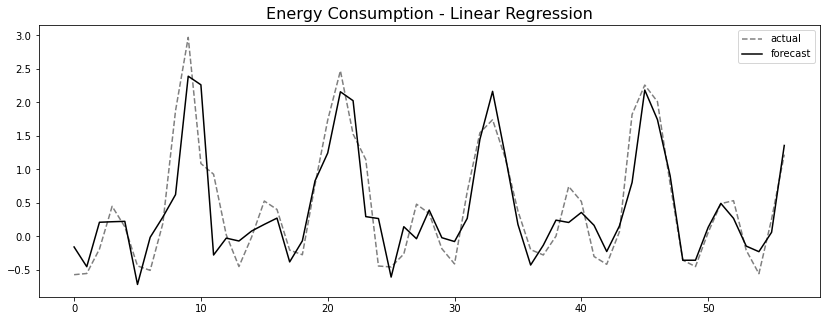

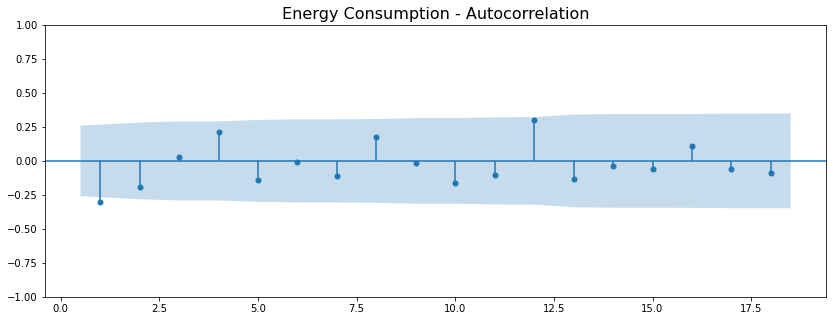

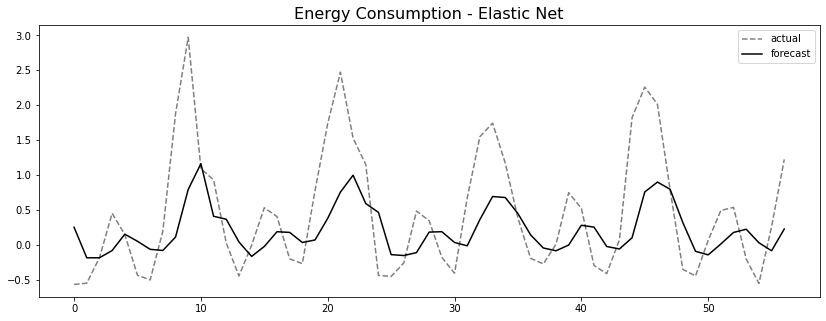

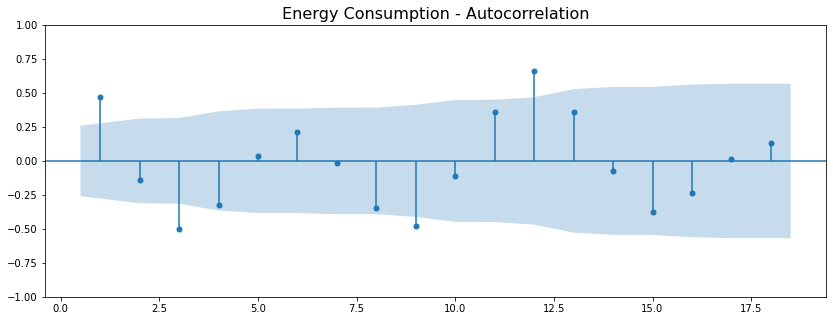

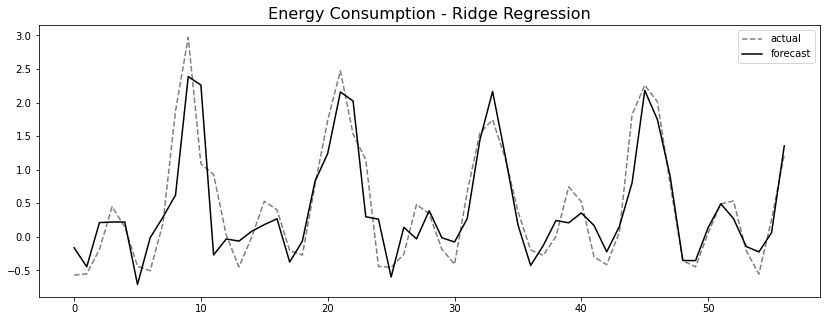

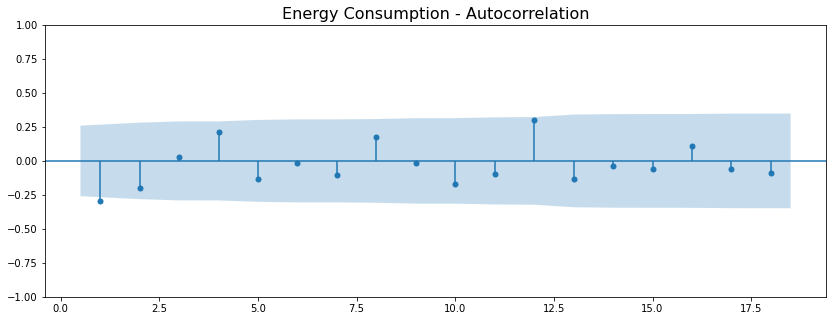

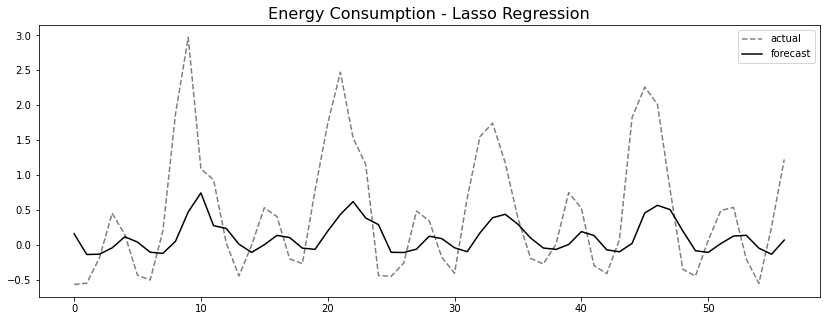

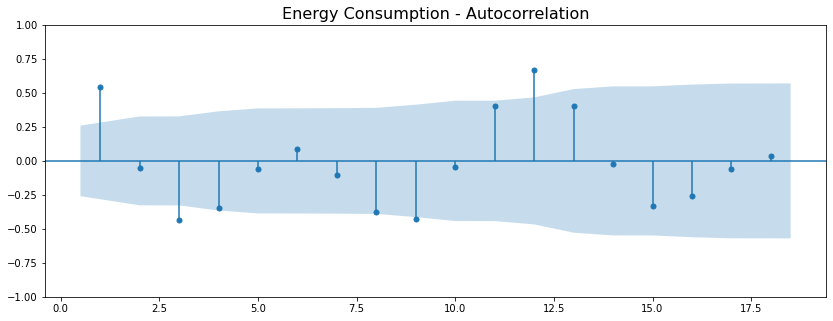

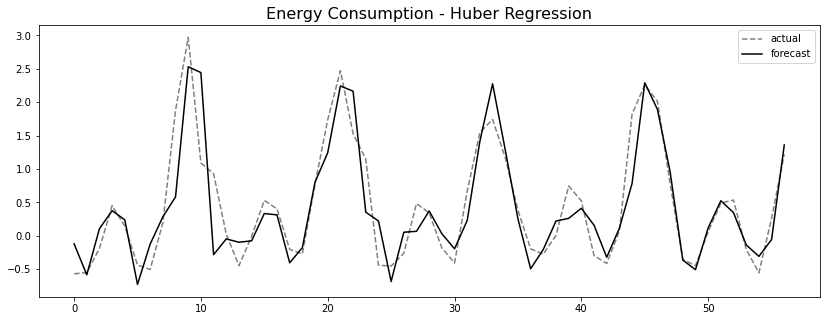

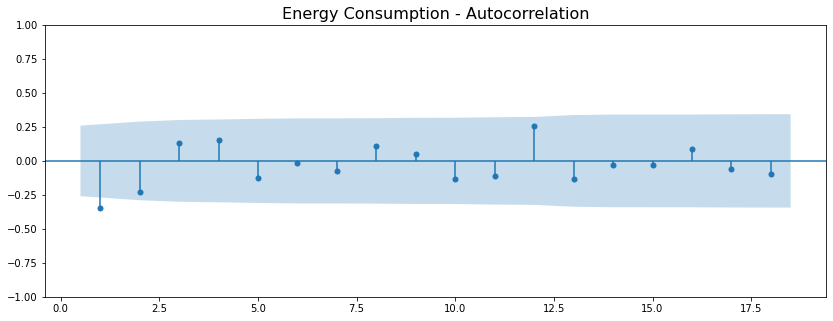

In [59]:
plot_results(cols, en_results, 'Energy Consumption')

#### Daily Temperature Plots

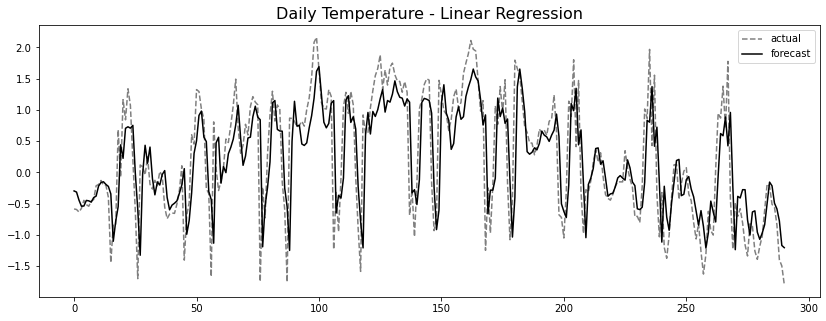

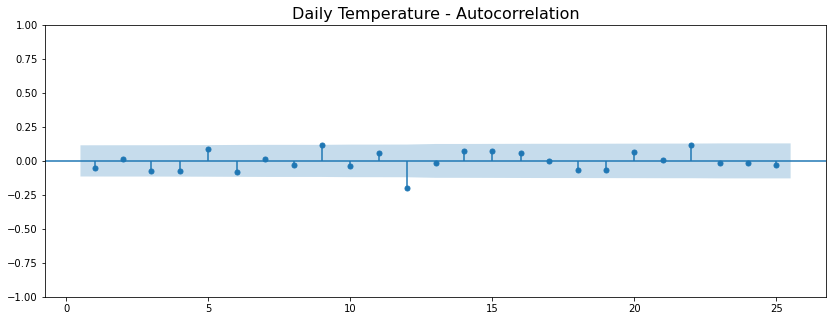

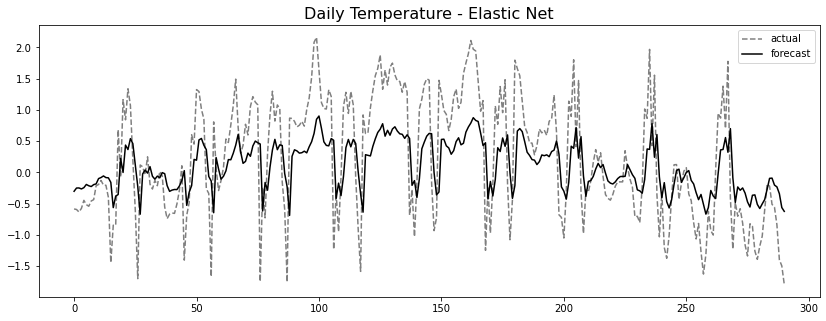

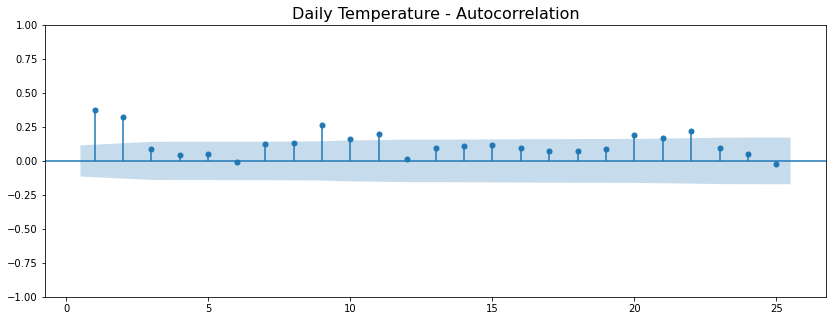

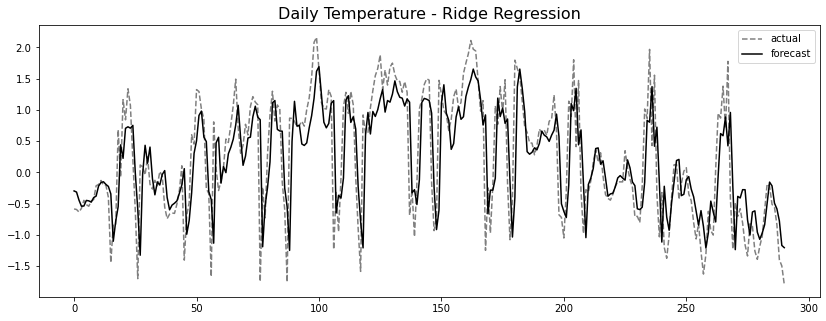

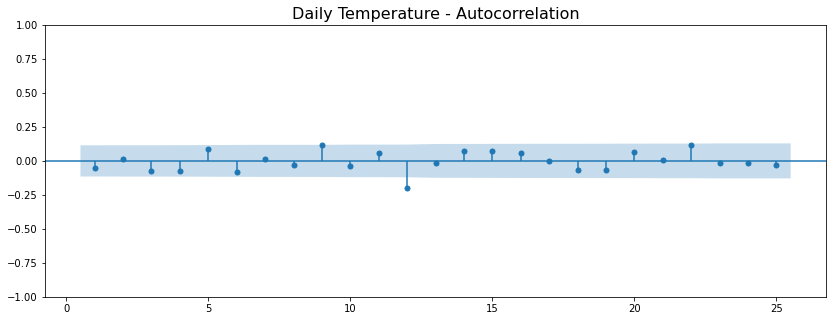

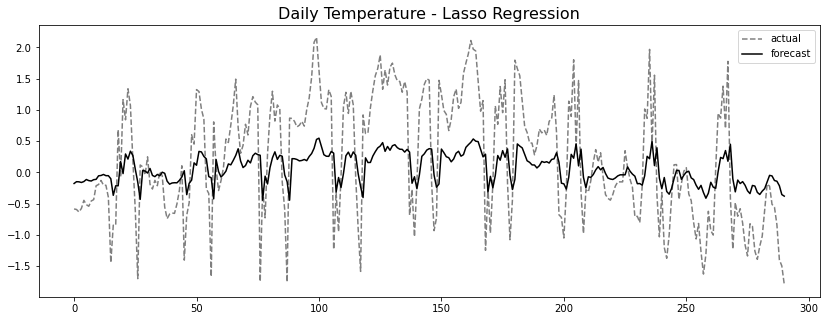

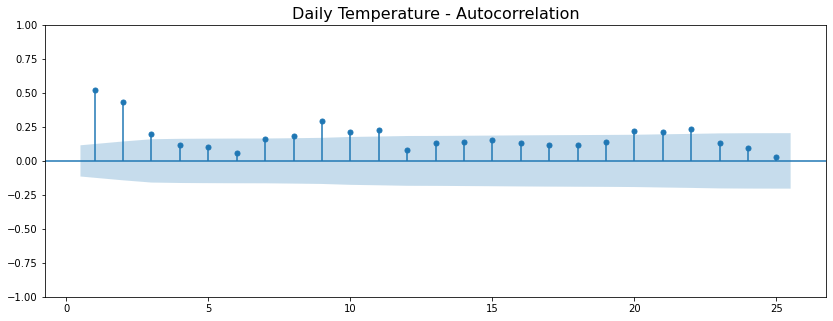

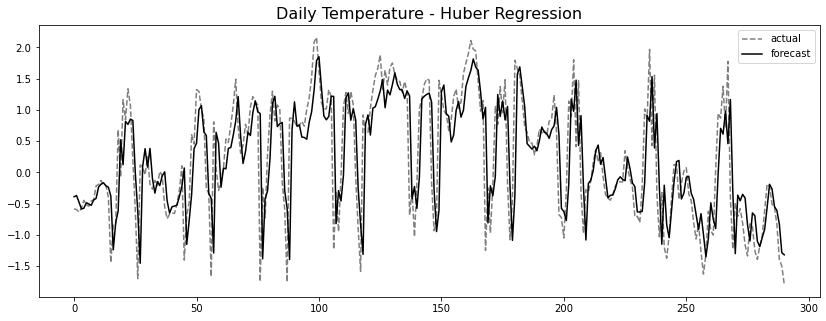

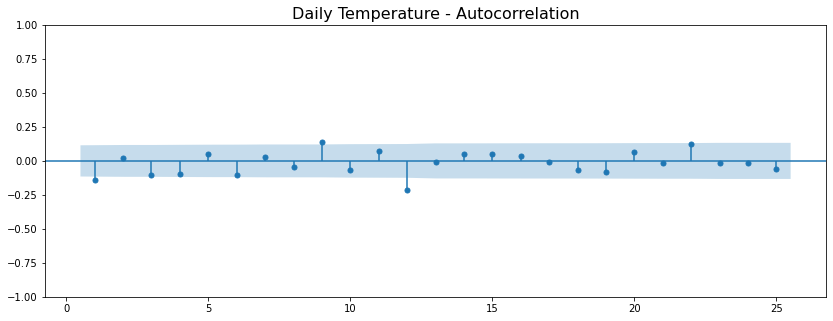

In [60]:
plot_results(cols, dw_results, 'Daily Temperature')

## How it works

In [62]:
cols = ['Model Name', 'Model']
en_models = en_results.iloc[0:4][cols]

for row in en_models.iterrows():
    print(row[1][0])
    print(row[1][1].coef_)

Linear Regression
[ 0.02739136  0.02052173  0.03768302  0.06630472  0.01417452 -0.08727704
  0.02856578 -0.13640839  0.14165493  0.70683461]
Elastic Net
[0.         0.         0.         0.         0.         0.
 0.         0.         0.04077799 0.37835549]
Ridge Regression
[ 0.0273999   0.02054709  0.0377177   0.06625515  0.01414968 -0.08721396
  0.02844889 -0.13622568  0.14175768  0.7065417 ]
Lasso Regression
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.2536153]


### Energy Consumption

**Regression Coefficients and Feature Selection**

In [63]:
en_10 = en_reg[['y', 'x_10']]

train_en10, test_en10 = split_data(en_10, test_split=0.10)
scaler_en10 = Standardize()
train_en10_s, test_en10_s = scaler_en.fit_transform(train_en10, test_en10)

en_10_results = train_different_models(train_en10_s, test_en10_s, regressors)

cols = ['Model Name', 'RMSE', 'MAPE', 'MASE']
en_10_results = pd.DataFrame(en_results)
en_10_results[cols].sort_values('MASE')

training Linear Regression ...
training Elastic Net ...
training Ridge Regression ...
training Lasso Regression ...
training Huber Regression ...


Model Name      RMSE      MAPE      MASE
4   Huber Regression  0.431651  0.729910  0.525526
2   Ridge Regression  0.433192  0.819432  0.560450
0  Linear Regression  0.433747  0.818459  0.560989
1        Elastic Net  0.747657  1.398025  1.013425
3   Lasso Regression  0.834356  1.502494  1.108092

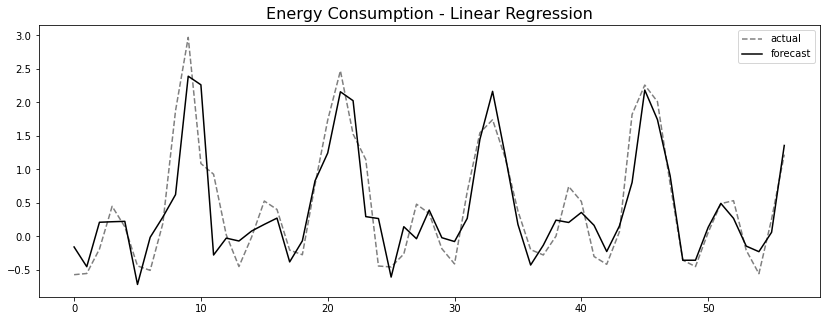

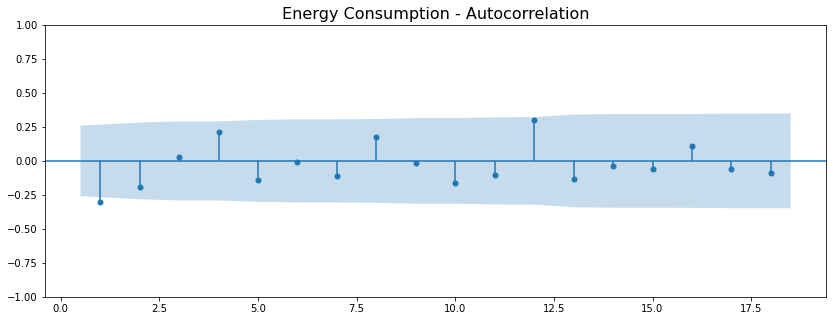

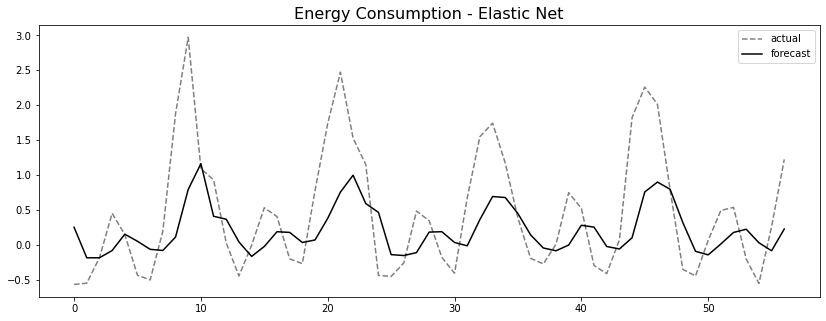

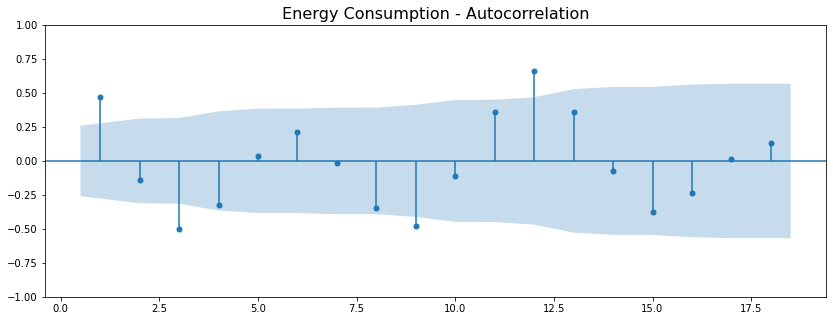

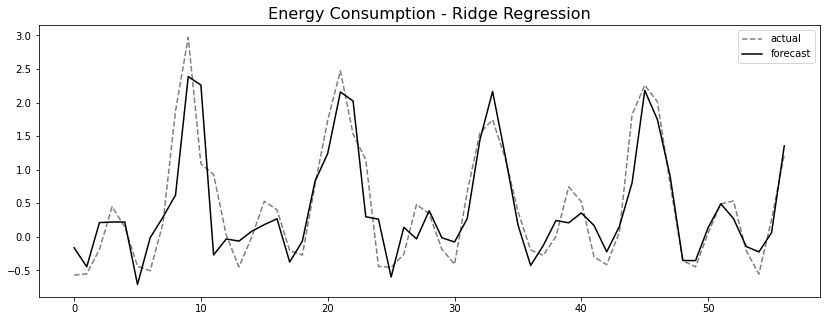

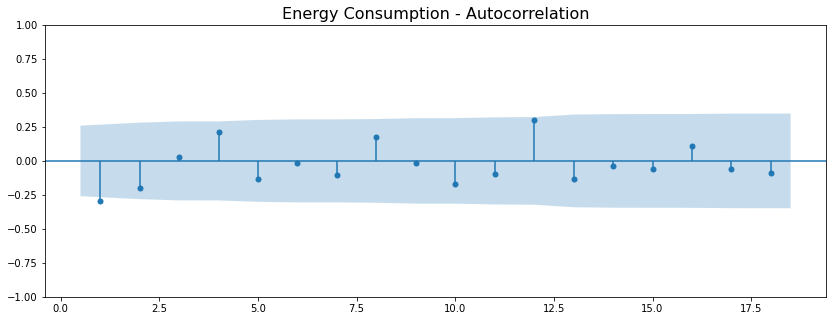

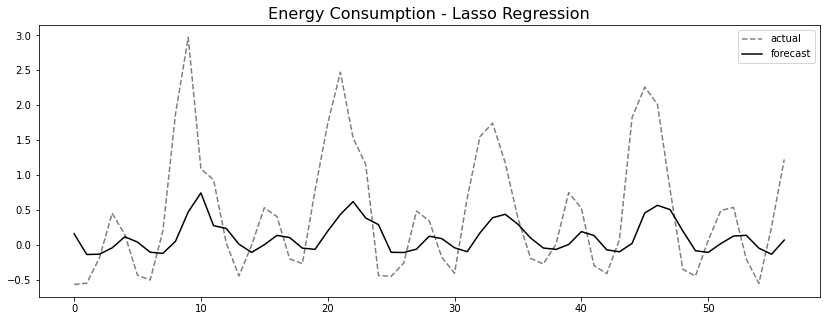

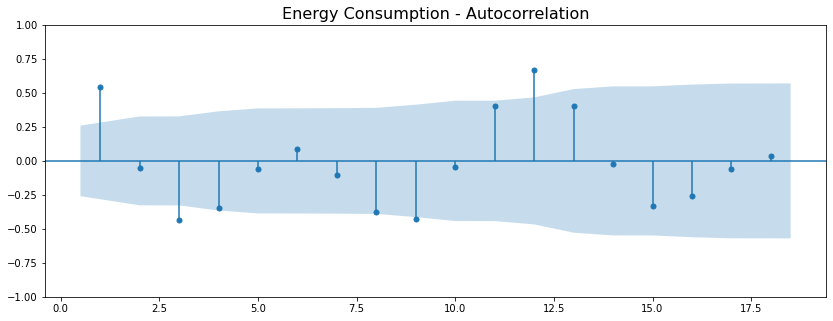

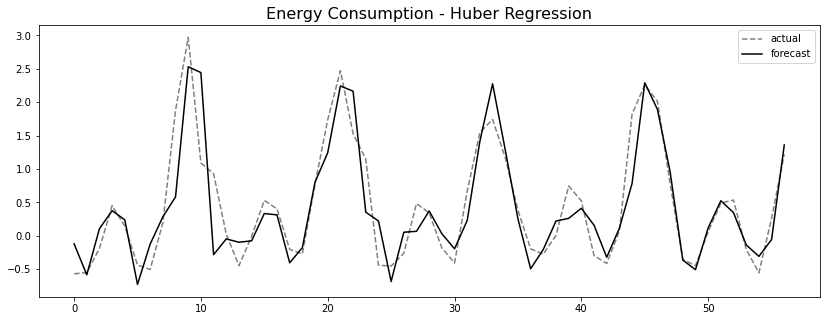

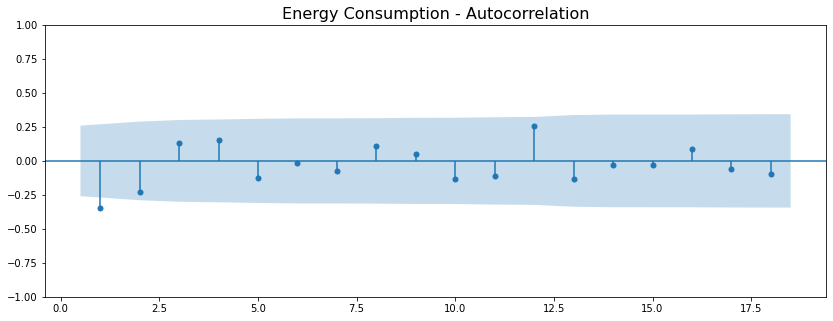

In [64]:
cols = ['yhat', 'resid', 'actual', 'Model Name']
plot_results(cols, en_10_results, 'Energy Consumption')

In [75]:
cols = ['Model Name', 'Model']
en_models = en_10_results.iloc[0:4][cols]

for row in en_models.iterrows():
    print(row[1][0])
    print(row[1][1].coef_)

Linear Regression
[0.75051783]
Elastic Net
[0.39987585]
Ridge Regression
[0.74979687]
Lasso Regression
[0.24955629]


# Multi-Step Forecasting 

In [150]:
test_dw_s.iloc[[-1]]

x_1       x_2       x_3       x_4       x_5       x_6  \
DateTime                                                                 
2016-12-22 -1.180203 -1.022581 -0.604237 -0.189764 -0.224464 -0.514589   

                 x_7       x_8       x_9      x_10         y  
DateTime                                                      
2016-12-22 -0.559203 -0.839812 -1.397096 -1.496642 -1.792546

In [151]:
models = dw_results[['Model Name','Model']]
models

Model Name                                       Model
0  Linear Regression       LinearRegression(fit_intercept=False)
1        Elastic Net  ElasticNet(alpha=0.5, fit_intercept=False)
2   Ridge Regression       Ridge(alpha=0.5, fit_intercept=False)
3   Lasso Regression       Lasso(alpha=0.5, fit_intercept=False)
4   Huber Regression         HuberRegressor(fit_intercept=False)

In [152]:
# another version using NumPy
# def multi_step_forecast(data, model, steps=10):
#     forecast = []
#     for i in range(steps):
#         one_step_pred = model.predict(data.reshape(1,-1))[0]
#         forecast.append(one_step_pred)
#         data = np.roll(data, shift=-1)
#         data[-1] = one_step_pred
#     return np.array(forecast)

In [153]:
def multi_step_forecast(data, model, steps=10):
    forecast = []
    for i in range(steps):
        one_step_pred = model.predict(np.array(data).reshape(1,-1))[0]
        forecast.append(one_step_pred)
        _ = data.pop(0)
        data.append(one_step_pred)
    return np.array(forecast)

### Daily Temperature

In [157]:
results = {}
models = dw_results[['Model Name','Model']]
dw_ms = test_dw_s.drop(columns=['y']).iloc[-1].tolist()

for i in models.iterrows():
    pred = multi_step_forecast(dw_ms, steps=10, model=i[1]['Model'])
    pred = scaler_dw.inverse_y(pred)
    results[i[1]['Model Name']] = pred    

### Air Passengers

In [136]:
# models = air_results[['Model Name','Model']]
# air_ms = test_air.drop(columns=['y']).iloc[-1].tolist()
# results = {}
# for i in models.iterrows():
#     pred = multi_step_forecast(air_ms, steps=10, model=i[1]['Model'])
#     pred = scaler_air.inverse_y(pred)
#     results[i[1]['Model Name']] = pred   

### Energy Consumption

In [156]:
# models = en_results[['Model Name','Model']]
# en_ms = test_en_s.drop(columns=['y']).iloc[-1].tolist()
# results = {}
# for i in models.iterrows():
#     pred = multi_step_forecast(en_ms, steps=10, model=i[1]['Model'])
#     pred = scaler_en.inverse_y(pred)
#     results[i[1]['Model Name']] = pred   

#### Example on Daily Temperature Data

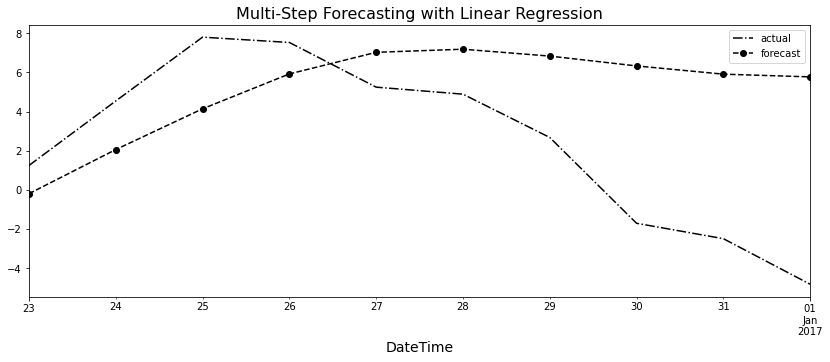

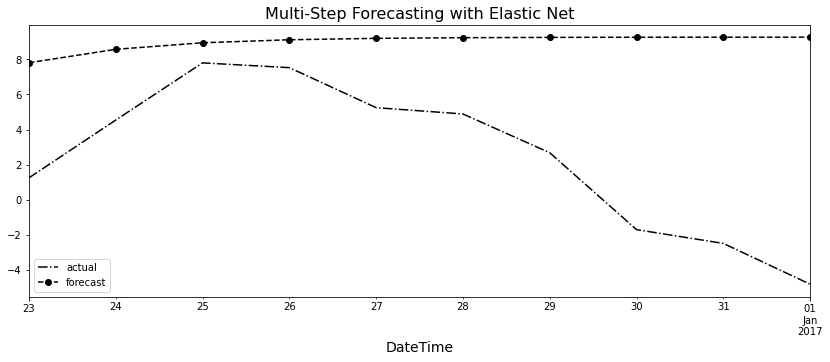

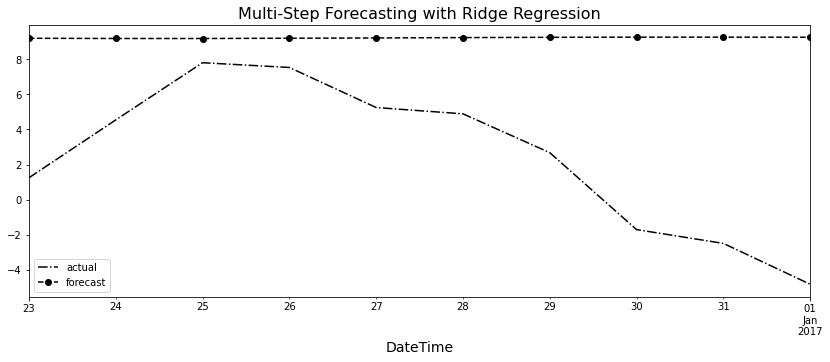

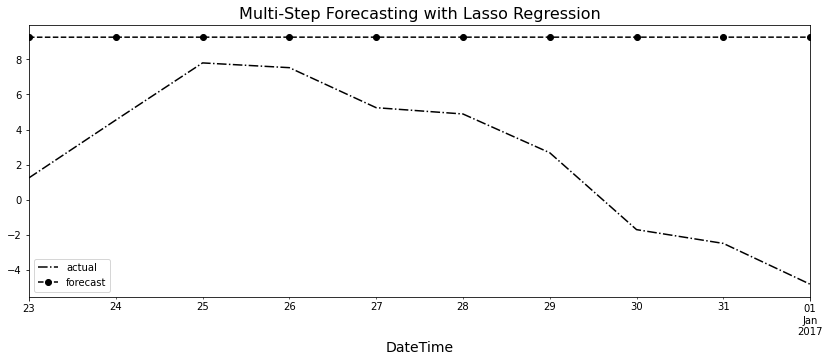

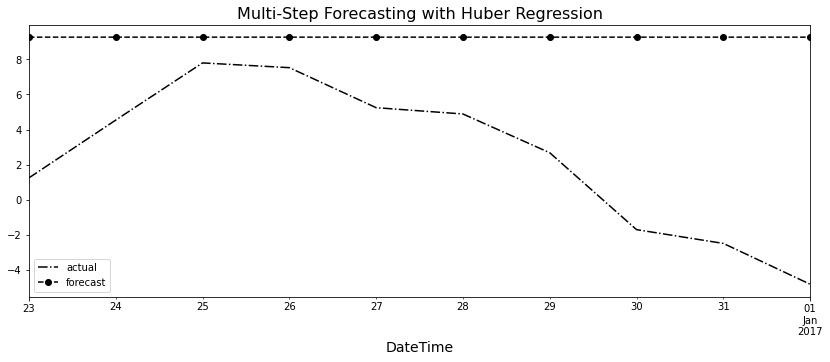

In [158]:
for name, pred in results.items():
    actual = dw_cp.iloc[-10:]
    ax = actual.plot(style='k-.')
    pd.Series(pred, index=dw_cp.index[-10:]).plot(style='k--o', ax=ax)
    plt.title(f'Multi-Step Forecasting with {name}')
    plt.legend(['actual', 'forecast'])
    plt.show()

In [97]:
# dw_ms = X_test.iloc[-1].values
# pred = scale_dw.inverse_y(multi_step(dw_ms, steps=10, model=rf))

# actual = dw_cp.iloc[-10:]

# ax = actual.plot(style='k-.')
# pd.Series(pred, index=dw_cp.index[-10:]).plot(style='k--o', ax=ax)
# plt.title('Multi-Step Forecasting with Random Forests')
# plt.legend(['actual', 'forecast'])


In [96]:
# dw_ms = X_test.iloc[-1].values
# pred = scale_dw.inverse_y(multi_step(dw_ms, steps=10, model=gb))

# actual = dw_cp.iloc[-10:]

# ax = actual.plot(style='k-.')
# pd.Series(pred, index=dw_cp.index[-10:]).plot(style='k--o', ax=ax)
# plt.title('Multi-Step Forecasting with Gradient Boosting')
# plt.legend(['actual', 'forecast'])

In [95]:
# dw_cp.iloc[-120:].plot(style='k--')

In [94]:
# steps = 20
# actual = dw_cp.iloc[-10:]
# pred = scale_dw.inverse_y(multi_step(dw_ms, steps=steps, model=gb))
# idx = pd.date_range(dw_cp.index[-10], periods=steps)
# ax = actual.plot(style='k-.')
# pd.Series(pred, index=idx).plot(style='k--o', ax=ax)
# plt.title('Multi-Step Forecasting with Gradient Boosting')
# plt.legend(['actual', 'forecast'])

In [93]:
# actual = dw_cp.iloc[-10:] 
# pred = scale_dw.inverse_y(multi_step(dw_ms, steps=steps, model=lr))
# idx = pd.date_range(dw_cp.index[-10], periods=steps)
# ax = actual.plot(style='k-.')
# pd.Series(pred, index=idx).plot(style='k--o', ax=ax)
# plt.title('Multi-Step Forecasting with Linear Regression')
# plt.legend(['actual', 'forecast'])

In [92]:
# actual = dw_cp.iloc[-10:]
# pred = scale_dw.inverse_y(multi_step(dw_ms, steps=steps, model=rf))
# idx = pd.date_range(dw_cp.index[-10], periods=steps)
# ax = actual.plot(style='k-.')
# pd.Series(pred, index=idx).plot(style='k--o', ax=ax)
# plt.title('Multi-Step Forecasting with Random Forest')
# plt.legend(['actual', 'forecast'])

## There is more

In [234]:
def multiple_output(df, window_in, window_out):
    d = df.values
    x = []
    y = []
    n = len(df)
    idx = df.index[:-window_in]
    print(len(idx))
    for start in range(n-window_in):
        end = start + window_in
        out = end + window_out
        x.append(d[start:end].ravel())
        y.append(d[end:out].ravel())
        
    cols_x = [f'x_{i}' for i in range(1, window_in+1)]
    cols_y = [f'y_{i}' for i in range(1, window_out+1)]

    df_xs = pd.DataFrame(x,  index=idx, columns=cols_x)
    df_y = pd.DataFrame(y,index=idx, columns=cols_y)
    return pd.concat([df_xs, df_y], axis=1).dropna()

In [235]:
win_in, win_out = 10, 10
dw_mo = multiple_output(dw_cp, win_in, win_out)

train_dw, test_dw = split_data(dw_mo, test_split=0.10)
scaler_dw = Standardize()
train_dw_s, test_dw_s = scaler_dw.fit_transform(train_dw,test_dw)

2913


In [236]:
dw_mo.columns

Index(['x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'x_10',
       'y_1', 'y_2', 'y_3', 'y_4', 'y_5', 'y_6', 'y_7', 'y_8', 'y_9', 'y_10'],
      dtype='object')

In [237]:
train_dw_s.shape

(2614, 20)

In [238]:
lr = LinearRegression()

In [239]:
X_train, y_train = train_dw_s.iloc[: , :win_in], train_dw_s.iloc[:, win_out:]
X_test, y_test = test_dw_s.iloc[: , :win_in], test_dw_s.iloc[:, win_out:]

In [240]:
lr.fit(X_train, y_train)

LinearRegression()

In [241]:
mo_pred = scaler_dw.inverse_y(lr.predict(X_test)[-1])
dates = pd.date_range('2016-12-13', freq='D', periods=20)
inputs, outputs = dates[:win_in], dates[win_out:]

In [245]:
test_dw.iloc[-1].values.shape

(20,)

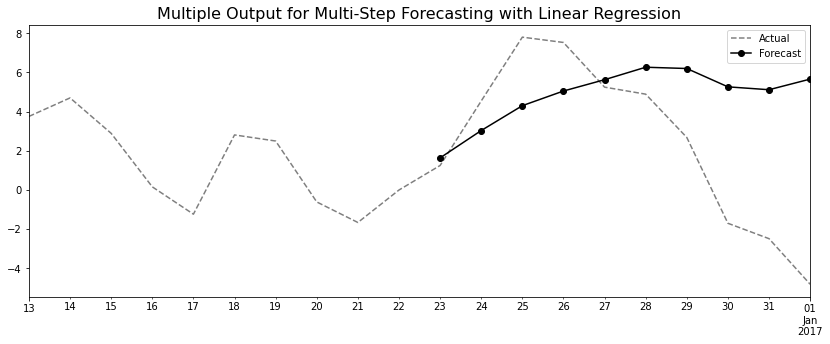

In [252]:
pd.Series(test_dw.iloc[-1].values, index=dates).plot(style='k--', alpha=0.5)
pd.Series(mo_pred, index=outputs).plot(style='k-o')
plt.title('Multiple Output for Multi-Step Forecasting with Linear Regression')
plt.legend(['Actual', 'Forecast'])
plt.savefig('../../../Packt-Time-Series-Cookbook/Chapters/Ch12/images/fig_12.10.png', bbox_inches='tight', dpi=600)

# Forecasting with sktime

Loading required modules

In [295]:
from sklearn.ensemble import (RandomForestRegressor, 
                              GradientBoostingRegressor, 
                              ExtraTreesRegressor)


from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sktime.forecasting.all import (
        Deseasonalizer, Detrender, 
        temporal_train_test_split,
        mean_absolute_percentage_error as mape, 
        mean_squared_percentage_error as mspe,
        mean_squared_error as mse, 
        ForecastingHorizon, 
        NaiveForecaster,
        TransformedTargetForecaster,
        PolynomialTrendForecaster
)
from sktime.forecasting.compose import make_reduction


In [296]:
import sktime
sktime.__version__

'0.11.0'

Loading the dataset and inspecting the data

In [297]:
df = energy.copy()

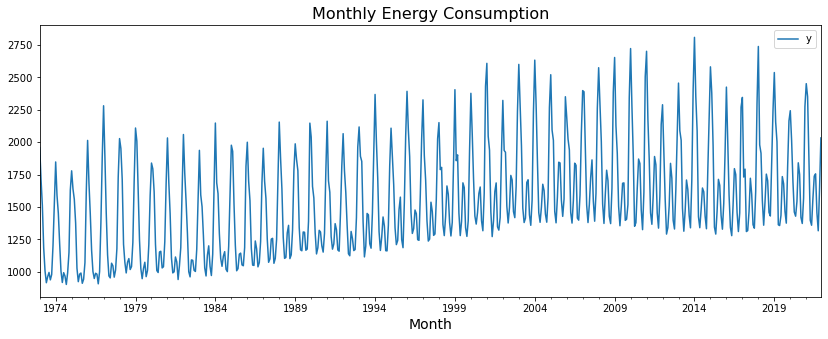

In [298]:
df.plot(title='Monthly Energy Consumption');plt.show()

In [299]:
df.head()

y
Month               
1973-01-01  1957.641
1973-02-01  1712.143
1973-03-01  1510.079
1973-04-01  1183.421
1973-05-01  1006.326

In [300]:
df.tail()

y
Month               
2021-08-01  1755.212
2021-09-01  1456.901
2021-10-01  1315.799
2021-11-01  1644.306
2021-12-01  2032.352

In [301]:
df.index.year.unique()

Int64Index([1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
            1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
            1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
            2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
            2017, 2018, 2019, 2020, 2021],
           dtype='int64', name='Month')

In [302]:
df.shape

(588, 1)

**Different ways to split your time series**


In [303]:
train, test = split_data(df)

In [304]:
train.shape

(500, 1)

In [305]:
test.shape

(88, 1)

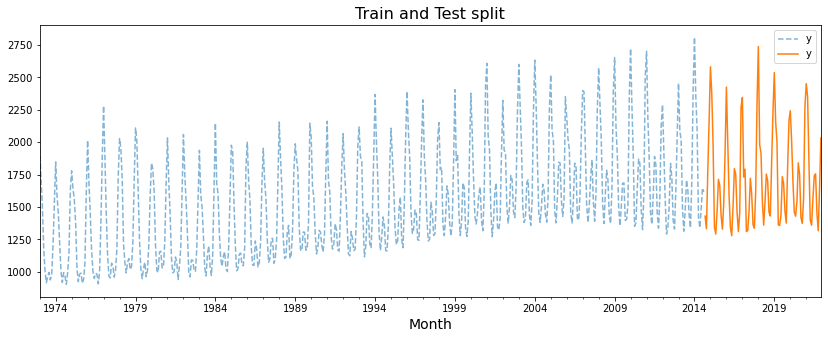

In [306]:
ax = train.plot(style='--', alpha=0.55)
test.plot(ax=ax)
plt.title('Train and Test split')
plt.show()

In [307]:
test.shape

(88, 1)

In [308]:
test.tail()

y
Month               
2021-08-01  1755.212
2021-09-01  1456.901
2021-10-01  1315.799
2021-11-01  1644.306
2021-12-01  2032.352

In [309]:
from statsmodels.tsa.api import seasonal_decompose, adfuller

In [310]:
adfuller(df)

(-1.4497331132437465,
 0.5582151234544193,
 12,
 575,
 {'1%': -3.4417738839904657,
  '5%': -2.8665796253604015,
  '10%': -2.569453974291115},
 6916.6482184861825)

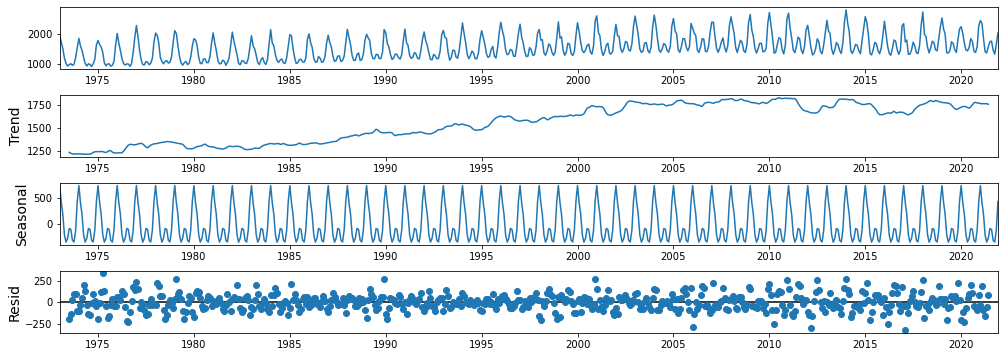

In [311]:
decomposed = seasonal_decompose(df)
decomposed.plot();

In [312]:
test.index

DatetimeIndex(['2014-09-01', '2014-10-01', '2014-11-01', '2014-12-01',
               '2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01',
               '2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01',
               '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01',
               '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01',
               '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
               '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
               '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01',
               '2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01',
               '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01',
               '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01',
               '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
      

In [313]:
def make_forecast(data, n, regressor, window=12):
    fh = ForecastingHorizon(np.arange(n) + 1, is_relative=True)
    forecaster = [
            ("deseasonalize", Deseasonalizer(sp=12, model="additive")),
            ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1)))]
    if not isinstance(regressor, NaiveForecaster):
        reg = ("forecaster", make_reduction(
            regressor,
            strategy='recursive',
            window_length=window,
            scitype='tabular-regressor'))
        forecaster.append(reg)
        model = TransformedTargetForecaster(forecaster).fit(data.values)
        
    else:
        model = regressor.fit(data.values)
    
    predicted = pd.Series(
            model.predict(fh=fh).reshape(-1),
            index= test.index
                    )
    return predicted

In [314]:
make_reduction(lr)

RecursiveTabularRegressionForecaster(estimator=LinearRegression())

In [315]:
regressors = {
            'Naive Forecaster' : NaiveForecaster(strategy='mean', sp=12),
            'Linear Regression': LinearRegression(),
            'K-NN Regressor': KNeighborsRegressor(n_neighbors=5),
            'Extra Tree Regressor': ExtraTreesRegressor(),
            'Random Forest Regressor': RandomForestRegressor(),
            'Gradient Boosting Regressor': GradientBoostingRegressor()
            }

for k, reg in regressors.items():
    print(f'training {reg} ...')
    test[k] = make_forecast(train, len(test), regressor=reg , window=15)

training NaiveForecaster(sp=12, strategy='mean') ...
training LinearRegression() ...
training KNeighborsRegressor() ...
training ExtraTreesRegressor() ...
training RandomForestRegressor() ...
training GradientBoostingRegressor() ...


In [316]:
test.shape

(88, 7)

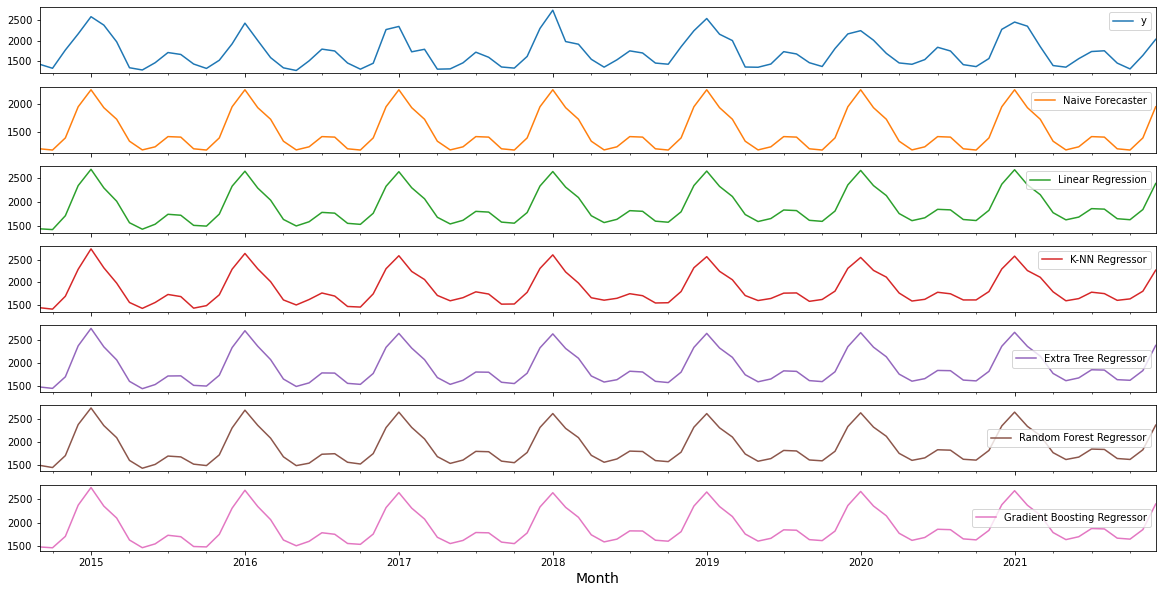

In [317]:
test.plot(subplots=True, figsize=(20, 10));plt.show()

<AxesSubplot:xlabel='Month'>

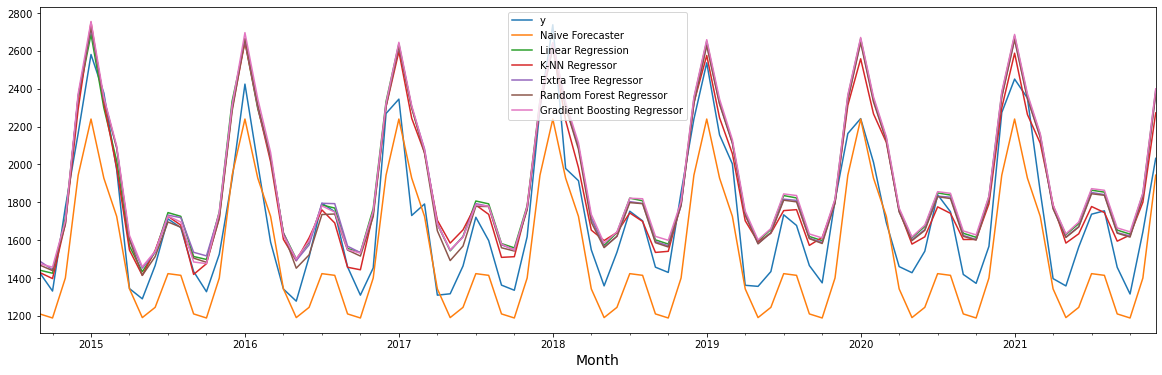

In [289]:
test.plot(subplots=False, figsize=(20, 6))

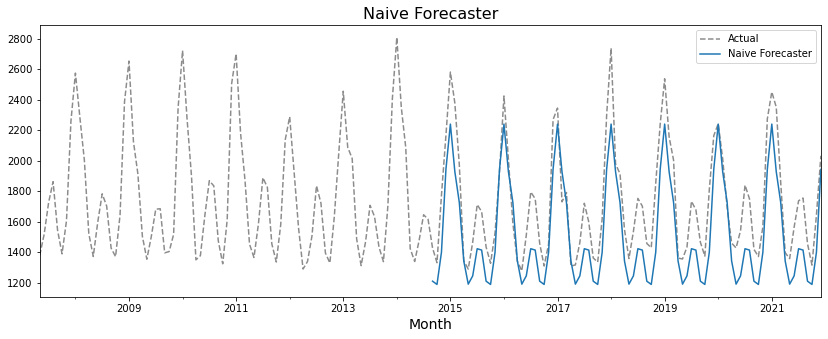

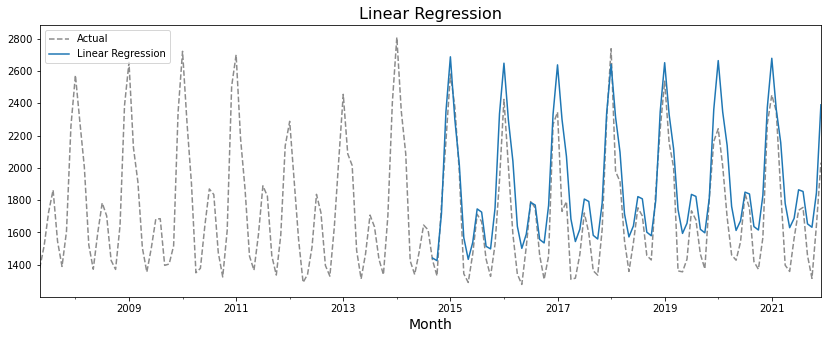

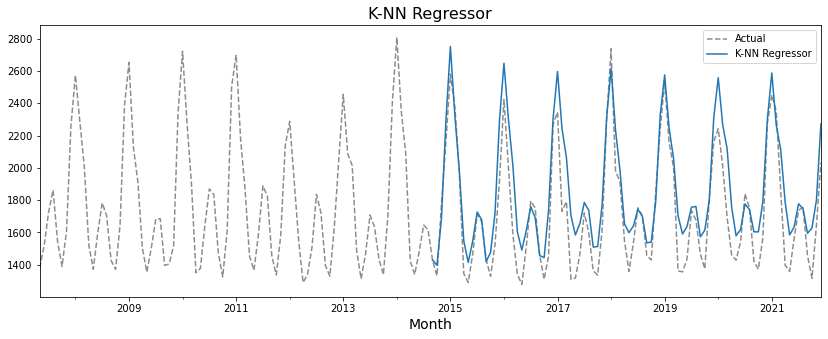

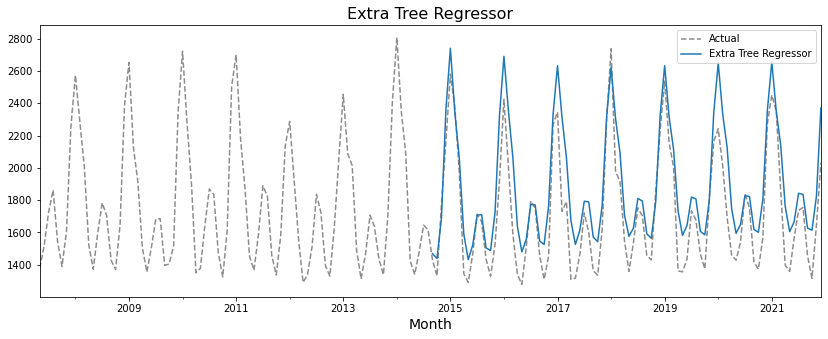

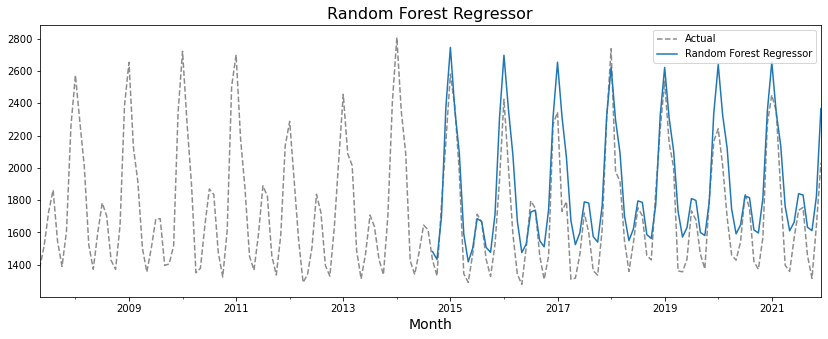

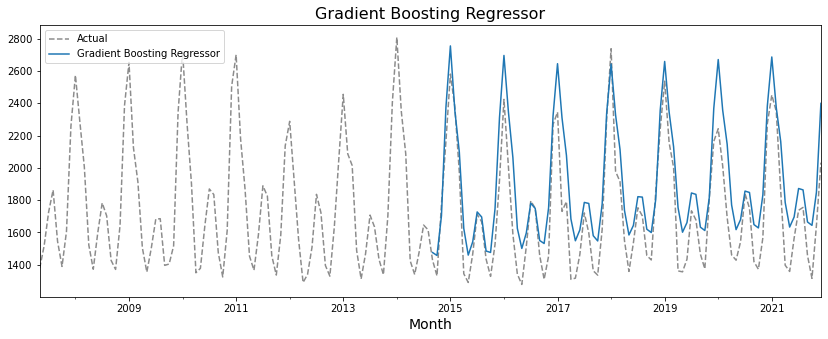

In [319]:
for i in test.iloc[: , 1:]:
    ax = df[-2*len(test):].plot(style='k--', alpha=0.45, title=i)
    test[i].plot(ax=ax)
    plt.legend(['Actual', i])
    plt.show()

In [331]:
test

y  Naive Forecaster  Linear Regression  K-NN Regressor  \
Month                                                                       
2014-09-01  1428.555       1210.663512        1441.612460     1429.364383   
2014-10-01  1331.478       1189.233073        1425.604618     1397.392401   
2014-11-01  1773.932       1400.315878        1715.650462     1686.999710   
2014-12-01  2164.807       1943.541073        2346.454781     2293.247940   
2015-01-01  2580.929       2239.992643        2687.958228     2751.156269   
...              ...               ...                ...             ...   
2021-08-01  1755.212       1414.440881        1853.913756     1746.050685   
2021-09-01  1456.901       1210.663512        1653.305608     1594.985762   
2021-10-01  1315.799       1189.233073        1632.237707     1627.545921   
2021-11-01  1644.306       1400.315878        1845.562098     1800.545450   
2021-12-01  2032.352       1943.541073        2390.649998     2272.226104   

            Extra Tree Regressor  Random Forest Regressor  \
Month                                                       
2014-09-01           1468.627824              1481.325647   
2014-10-01           1438.267753              1433.227424   
2014-11-01           1689.528006              1696.142047   
2014-12-01           2362.297029              2379.728070   
2015-01-01           2741.052016              2746.254164   
...                          ...                      ...   
2021-08-01           1835.873512              1832.180822   
2021-09-01           1627.500404              1632.336884   
2021-10-01           1614.097652              1611.573096   
2021-11-01           1824.539394              1824.537723   
2021-12-01           2371.115249              2367.449101   

            Gradient Boosting Regressor  
Month                                    
2014-09-01                  1475.804086  
2014-10-01                  1457.550039  
2014-11-01                  1703.186602  
2014-12-01                  2374.981222  
2015-01-01                  2755.411366  
...                                 ...  
2021-08-01                  1863.734586  
2021-09-01                  1664.976452  
2021-10-01                  1644.048373  
2021-11-01                  1849.229030  
2021-12-01                  2399.527030  

[88 rows x 7 columns]

In [340]:
def evaluate(df, train, sort_by='MASE'):
    evals = pd.DataFrame(index=['sMAPE', 'MAPE', 'RMSE'])
    y_truth = df['y']
    y_predicted = df.drop(columns=['y'])
    for p in y_predicted:
        evals.loc['sMAPE', p] = mape(y_truth, y_predicted[p], symmetric=True)
        evals.loc['MAPE', p] = mape(y_truth, y_predicted[p], symmetric=False)
        evals.loc['RMSE', p] = np.sqrt(mse(y_truth, y_predicted[p]))
        evals.loc['MASE', p] = mase(y_truth, y_predicted[p], y_train=train)
    return evals.T.sort_values(by=sort_by)
    

In [341]:
evaluate(test, train)

sMAPE      MAPE        RMSE      MASE
K-NN Regressor               0.088718  0.095485  192.449319  0.685551
Random Forest Regressor      0.099764  0.107576  211.802685  0.783351
Extra Tree Regressor         0.101279  0.109252  213.193772  0.794356
Linear Regression            0.105661  0.114187  219.063673  0.828132
Gradient Boosting Regressor  0.109251  0.118294  226.483574  0.860031
Naive Forecaster             0.133619  0.123643  242.222293  0.957688

In [343]:
evaluate(test, train, sort_by='RMSE')

sMAPE      MAPE        RMSE      MASE
K-NN Regressor               0.088718  0.095485  192.449319  0.685551
Random Forest Regressor      0.099764  0.107576  211.802685  0.783351
Extra Tree Regressor         0.101279  0.109252  213.193772  0.794356
Linear Regression            0.105661  0.114187  219.063673  0.828132
Gradient Boosting Regressor  0.109251  0.118294  226.483574  0.860031
Naive Forecaster             0.133619  0.123643  242.222293  0.957688

## There is more

In [344]:
from pmdarima import auto_arima
n = len(test)
fh = ForecastingHorizon(np.arange(n) + 1)
arima = auto_arima(y=train, seasonal=True, m=12, suppress_warnings=True)

In [345]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  500
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -2988.064
Date:                            Fri, 06 May 2022   AIC                           5984.127
Time:                                    00:08:04   BIC                           6000.978
Sample:                                         0   HQIC                          5990.740
                                            - 500                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4294      0.037    -11.718      0.000      -0.501      -0.358
ar.S.L12       0.9982      0.001    729.565      0.000       0.996       1.001
ma.S.L12      -0.7859      0.030    -26.582      0.000      -0.844      -0.728
sigma2      8549.7736    415.353     20.584      0.000    7735.696    9363.851
===================================================================================
Ljung-Box (L1) (Q):                   9.08   Jarque-Bera (JB):                70.21
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.77   Skew:                            -0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [346]:
test['ARIMA'] = arima.predict(n)

In [347]:
test.shape

(88, 8)

In [348]:
test.head()

y  Naive Forecaster  Linear Regression  K-NN Regressor  \
Month                                                                       
2014-09-01  1428.555       1210.663512        1441.612460     1429.364383   
2014-10-01  1331.478       1189.233073        1425.604618     1397.392401   
2014-11-01  1773.932       1400.315878        1715.650462     1686.999710   
2014-12-01  2164.807       1943.541073        2346.454781     2293.247940   
2015-01-01  2580.929       2239.992643        2687.958228     2751.156269   

            Extra Tree Regressor  Random Forest Regressor  \
Month                                                       
2014-09-01           1468.627824              1481.325647   
2014-10-01           1438.267753              1433.227424   
2014-11-01           1689.528006              1696.142047   
2014-12-01           2362.297029              2379.728070   
2015-01-01           2741.052016              2746.254164   

            Gradient Boosting Regressor        ARIMA  
Month                                                 
2014-09-01                  1475.804086  1338.851122  
2014-10-01                  1457.550039  1255.024031  
2014-11-01                  1703.186602  1517.822885  
2014-12-01                  2374.981222  2159.671149  
2015-01-01                  2755.411366  2461.472817

In [350]:
evaluate(test, train)

sMAPE      MAPE        RMSE      MASE
K-NN Regressor               0.088718  0.095485  192.449319  0.685551
ARIMA                        0.098918  0.093266  184.699337  0.705350
Random Forest Regressor      0.099764  0.107576  211.802685  0.783351
Extra Tree Regressor         0.101279  0.109252  213.193772  0.794356
Linear Regression            0.105661  0.114187  219.063673  0.828132
Gradient Boosting Regressor  0.109251  0.118294  226.483574  0.860031
Naive Forecaster             0.133619  0.123643  242.222293  0.957688

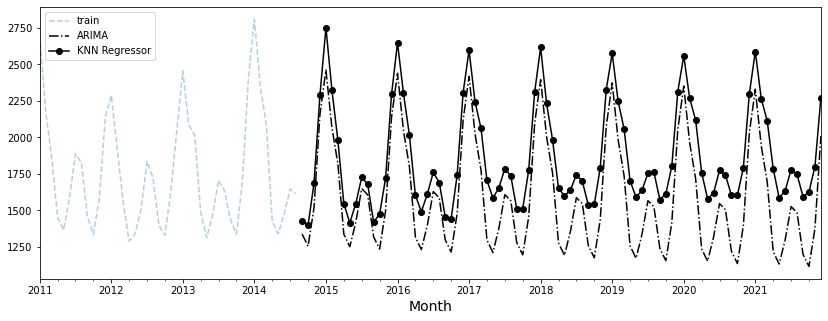

In [367]:
ax = train.loc['2011':].plot(style='--', alpha=0.35)
test['ARIMA'].plot(ax=ax, style='k-.')
test['K-NN Regressor'].plot(ax=ax, style='k-o')
# test['Naive Forecaster'].plot(ax=ax, style='.-')
plt.legend(['train', 'ARIMA', 'KNN Regressor'])
plt.savefig('../../../Packt-Time-Series-Cookbook/Chapters/Ch12/images/fig_12.14.png', bbox_inches='tight', dpi=600)

## Manual

## How it Works

```python
make_reduction(estimator, 
               strategy='recursive', 
               window_length=10, 
               scitype='infer')
```

# Optimizing a Machine Learning model with Hyperparameter Tuning

In [370]:
from sktime.forecasting.all import (
        ForecastingGridSearchCV, 
        SlidingWindowSplitter,
        MeanAbsolutePercentageError)

In [371]:
df = energy.copy()

In [374]:
train, test = split_data(df)

In [375]:
test.shape

(88, 1)

In [379]:
n = len(test)
fh = ForecastingHorizon(np.arange(n) + 1, is_relative=True)
forecaster = TransformedTargetForecaster(
    [("deseasonalize", Deseasonalizer(model="multiplicative", sp=12)),
     ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
     ("forecast",
            make_reduction(
                KNeighborsRegressor(),
                scitype="tabular-regressor",
                window_length=12,
                strategy="recursive",
            ), ),  ])

In [380]:
forecaster.fit(train.values)
test['KNN-Regressor'] = forecaster.predict(fh)

In [381]:
test.head()

y  KNN-Regressor
Month                              
2014-09-01  1428.555    1404.930420
2014-10-01  1331.478    1400.715430
2014-11-01  1773.932    1733.417657
2014-12-01  2164.807    2333.941613
2015-01-01  2580.929    2777.382750

In [383]:
evaluate(test, train)

sMAPE      MAPE        RMSE      MASE
KNN-Regressor  0.090378  0.097746  225.568315  0.751772

In [ ]:
KNeighborsRegressor()

In [384]:
forecaster.get_params()

{'steps': [('deseasonalize', Deseasonalizer(model='multiplicative', sp=12)),
  ('detrend', Detrender(forecaster=PolynomialTrendForecaster())),
  ('forecast',
   RecursiveTabularRegressionForecaster(estimator=KNeighborsRegressor(),
                                        window_length=12))],
 'deseasonalize': Deseasonalizer(model='multiplicative', sp=12),
 'detrend': Detrender(forecaster=PolynomialTrendForecaster()),
 'forecast': RecursiveTabularRegressionForecaster(estimator=KNeighborsRegressor(),
                                      window_length=12),
 'deseasonalize__model': 'multiplicative',
 'deseasonalize__sp': 12,
 'detrend__forecaster__degree': 1,
 'detrend__forecaster__regressor': None,
 'detrend__forecaster__with_intercept': True,
 'detrend__forecaster': PolynomialTrendForecaster(),
 'forecast__estimator__algorithm': 'auto',
 'forecast__estimator__leaf_size': 30,
 'forecast__estimator__metric': 'minkowski',
 'forecast__estimator__metric_params': None,
 'forecast__estimator__n

In [385]:
forecaster.get_params().keys()

dict_keys(['steps', 'deseasonalize', 'detrend', 'forecast', 'deseasonalize__model', 'deseasonalize__sp', 'detrend__forecaster__degree', 'detrend__forecaster__regressor', 'detrend__forecaster__with_intercept', 'detrend__forecaster', 'forecast__estimator__algorithm', 'forecast__estimator__leaf_size', 'forecast__estimator__metric', 'forecast__estimator__metric_params', 'forecast__estimator__n_jobs', 'forecast__estimator__n_neighbors', 'forecast__estimator__p', 'forecast__estimator__weights', 'forecast__estimator', 'forecast__window_length'])

In [387]:
[i for i in range(3,11)]

[3, 4, 5, 6, 7, 8, 9, 10]

In [388]:
# example grid search space
hyperparams_grid = {
    "forecast__estimator__n_neighbors": [i for i in range(3,11)],
    "deseasonalize__model": ['multiplicative', 'additive'],
    "forecast__estimator__p": [1,2]
}

In [409]:
cv = SlidingWindowSplitter(window_length=int(len(df) * 0.70), fh=fh)
smape = MeanAbsolutePercentageError(symmetric=True)

grid_csv = ForecastingGridSearchCV(
    forecaster, 
    strategy="refit", 
    cv=cv,
    param_grid=hyperparams_grid, 
    scoring=smape,
    return_n_best_forecasters=1,
    verbose=1
)

In [410]:
grid_csv.cv

SlidingWindowSplitter(fh=ForecastingHorizon([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
            52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
            69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
            86, 87, 88],
           dtype='int64', is_relative=True),
           window_length=411)

In [413]:
fh

ForecastingHorizon([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
            52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
            69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
            86, 87, 88],
           dtype='int64', is_relative=True)

In [411]:
grid_csv.fit(train.values, fh=fh)

Fitting 2 folds for each of 32 candidates, totalling 64 fits


ForecastingGridSearchCV(cv=SlidingWindowSplitter(fh=ForecastingHorizon([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
            52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
            69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
            86, 87, 88],
           dtype='int64', is_relat...
                                                                       Detrender(forecaster=PolynomialTrendForecaster())),
                                                                      ('forecast',
                                                                       RecursiveTabularRegressionForecaster(estimator=KNeighborsRegressor(),
                                                                                                            window_length=12))]),


In [414]:
grid_csv.best_forecaster_

TransformedTargetForecaster(steps=[('deseasonalize', Deseasonalizer(sp=12)),
                                   ('detrend',
                                    Detrender(forecaster=PolynomialTrendForecaster())),
                                   ('forecast',
                                    RecursiveTabularRegressionForecaster(estimator=KNeighborsRegressor(n_neighbors=7),
                                                                         window_length=12))])

In [415]:
grid_csv.best_params_

{'deseasonalize__model': 'additive',
 'forecast__estimator__n_neighbors': 7,
 'forecast__estimator__p': 2}

In [227]:
grid_csv.cv_results_

In [416]:
test['KNN_optimized'] = grid_csv.predict(fh)

In [418]:
evaluate(test, train)

sMAPE      MAPE        RMSE      MASE
KNN_optimized  0.088823  0.095325  188.102334  0.684741
KNN-Regressor  0.090378  0.097746  225.568315  0.751772

In [422]:
grid_csv.cv_results_

mean_test_MeanAbsolutePercentageError  mean_fit_time  mean_pred_time  \
0                                0.068065       0.016563        0.056924   
1                                0.066450       0.014689        0.048589   
2                                0.065952       0.011099        0.039758   
3                                0.064853       0.010719        0.040007   
4                                0.064658       0.011781        0.044194   
5                                0.062486       0.010854        0.039801   
6                                0.064220       0.012070        0.044795   
7                                0.065216       0.016180        0.056152   
8                                0.066626       0.012206        0.044138   
9                                0.065606       0.012415        0.044709   
10                               0.065828       0.014494        0.048660   
11                               0.066243       0.015476        0.057396   
12                               0.067104       0.018240        0.053027   
13                               0.065111       0.015567        0.055326   
14                               0.066061       0.021650        0.074464   
15                               0.066096       0.018636        0.071159   
16                               0.068791       0.018379        0.067672   
17                               0.063391       0.013776        0.052384   
18                               0.065888       0.012850        0.048044   
19                               0.062623       0.011584        0.041922   
20                               0.064386       0.012100        0.043517   
21                               0.066547       0.011611        0.048224   
22                               0.068606       0.011266        0.040901   
23                               0.066154       0.011667        0.044592   
24                               0.069438       0.015396        0.046966   
25                               0.062401       0.012846        0.041194   
26                               0.065195       0.011219        0.046677   
27                               0.062890       0.015797        0.083158   
28                               0.068173       0.019884        0.066838   
29                               0.063770       0.020445        0.077420   
30                               0.065876       0.018890        0.062244   
31                               0.064710       0.012687        0.046553   

                                               params  \
0   {'deseasonalize__model': 'multiplicative', 'fo...   
1   {'deseasonalize__model': 'multiplicative', 'fo...   
2   {'deseasonalize__model': 'multiplicative', 'fo...   
3   {'deseasonalize__model': 'multiplicative', 'fo...   
4   {'deseasonalize__model': 'multiplicative', 'fo...   
5   {'deseasonalize__model': 'multiplicative', 'fo...   
6   {'deseasonalize__model': 'multiplicative', 'fo...   
7   {'deseasonalize__model': 'multiplicative', 'fo...   
8   {'deseasonalize__model': 'multiplicative', 'fo...   
9   {'deseasonalize__model': 'multiplicative', 'fo...   
10  {'deseasonalize__model': 'multiplicative', 'fo...   
11  {'deseasonalize__model': 'multiplicative', 'fo...   
12  {'deseasonalize__model': 'multiplicative', 'fo...   
13  {'deseasonalize__model': 'multiplicative', 'fo...   
14  {'deseasonalize__model': 'multiplicative', 'fo...   
15  {'deseasonalize__model': 'multiplicative', 'fo...   
16  {'deseasonalize__model': 'additive', 'forecast...   
17  {'deseasonalize__model': 'additive', 'forecast...   
18  {'deseasonalize__model': 'additive', 'forecast...   
19  {'deseasonalize__model': 'additive', 'forecast...   
20  {'deseasonalize__model': 'additive', 'forecast...   
21  {'deseasonalize__model': 'additive', 'forecast...   
22  {'deseasonalize__model': 'additive', 'forecast...   
23  {'deseasonalize__model': 'additive', 'forecast...   
24  {'deseasonalize__model': 'additive', 'forecast...   
25  {'deseaso

In [419]:
model = grid_csv.best_forecaster_

In [217]:
model.get_params() 

{'steps': [('deseasonalize', Deseasonalizer(model='multiplicative', sp=12)),
  ('detrend', Detrender()),
  ('forecast',
   RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(max_depth=4,
                                                                        min_samples_split=5,
                                                                        n_estimators=500),
                                        window_length=12))],
 'deseasonalize': Deseasonalizer(model='multiplicative', sp=12),
 'detrend': Detrender(),
 'forecast': RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(max_depth=4,
                                                                      min_samples_split=5,
                                                                      n_estimators=500),
                                      window_length=12),
 'deseasonalize__model': 'multiplicative',
 'deseasonalize__sp': 12,
 'detrend__forecaster': None,
 'forecast__estimator__bootst

# Multivariate Forecasting and Ensemble Learning with sktime

In [423]:
from sktime.forecasting.all import EnsembleForecaster
from sklearn.svm import SVR
from sktime.transformations.series.detrend import ConditionalDeseasonalizer
from sktime.datasets import load_macroeconomic

In [247]:
load_macroeconomic().shape

(203, 12)

In [424]:
econ = load_macroeconomic()
cols = ['realgdp','realdpi','tbilrate', 'unemp', 'infl']
econ_df = econ[cols]

In [425]:
econ_df.shape

(203, 5)

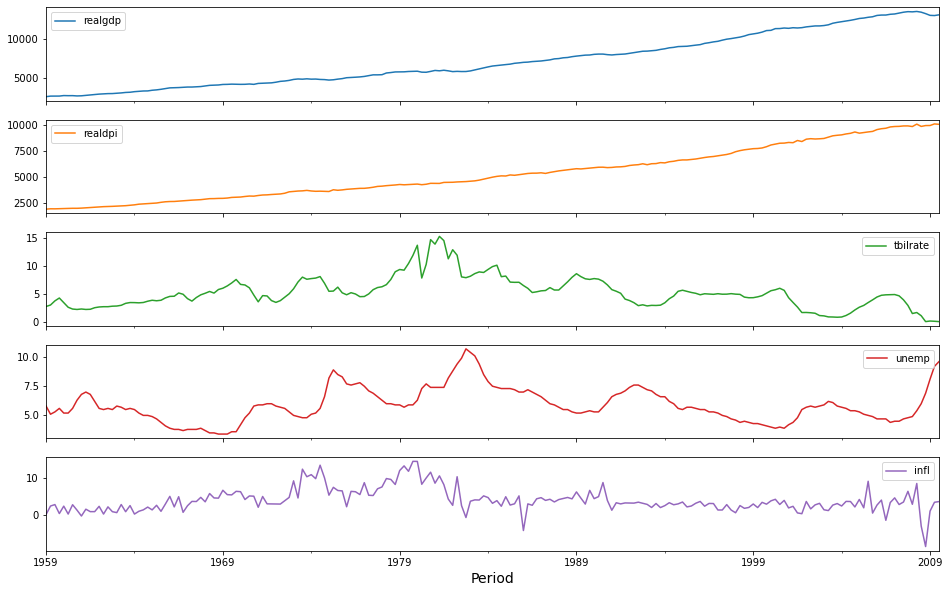

In [426]:
econ_df.plot(subplots=True, figsize=(16, 10));plt.show()

## How to do it

In [427]:
econ_df.head()

realgdp  realdpi  tbilrate  unemp  infl
Period                                          
1959Q1  2710.349   1886.9      2.82    5.8  0.00
1959Q2  2778.801   1919.7      3.08    5.1  2.34
1959Q3  2775.488   1916.4      3.82    5.3  2.74
1959Q4  2785.204   1931.3      4.33    5.6  0.27
1960Q1  2847.699   1955.5      3.50    5.2  2.31

In [428]:
cond_deseason = ConditionalDeseasonalizer(sp=4)
detrend = Detrender(forecaster=PolynomialTrendForecaster(degree=1))
for col in econ_df:
    econ_df[col] = cond_deseason.fit_transform(econ_df[col])
    econ_df[col] = detrend.fit_transform(econ_df[col])

In [429]:
y = econ_df['unemp']
exog = econ_df.drop(columns=['unemp'])

In [434]:
len(econ_df)*0.1

20.3

In [437]:
test_size = 0.1
y_train, y_test = split_data(y, test_split=test_size)
exog_train, exog_test = split_data(exog, test_split=test_size)

In [439]:
regressors = [
    ("LinearRegression", make_reduction(LinearRegression())),
    ("RandomForest", make_reduction(RandomForestRegressor())),
    ("SupportVectorRegressor", make_reduction(SVR())),
    ("GradientBoosting", make_reduction(GradientBoostingRegressor()))]

In [440]:
ensemble = EnsembleForecaster(regressors)
naive = NaiveForecaster()

In [441]:
ensemble.fit(y=y_train, X=exog_train)
naive.fit(y=y_train, X=exog_train)

NaiveForecaster()

In [449]:
fh = ForecastingHorizon(y_test.index, is_relative=None)

y_hat = pd.DataFrame(y_test).rename(columns={'unemp': 'test'})
y_hat['EnsembleForecaster'] = ensemble.predict(fh=fh, X=exog_test)
y_hat['NaiveForecaster'] = naive.predict(fh=fh, X=exog_test)

In [450]:
y_hat.rename(columns={'test':'y'}, inplace=True)

In [451]:
evaluate(y_hat, y_train)

sMAPE      MAPE      RMSE      MASE
EnsembleForecaster  1.211790  1.000520  1.338320  4.454848
NaiveForecaster     0.946033  2.490779  1.537844  4.522654

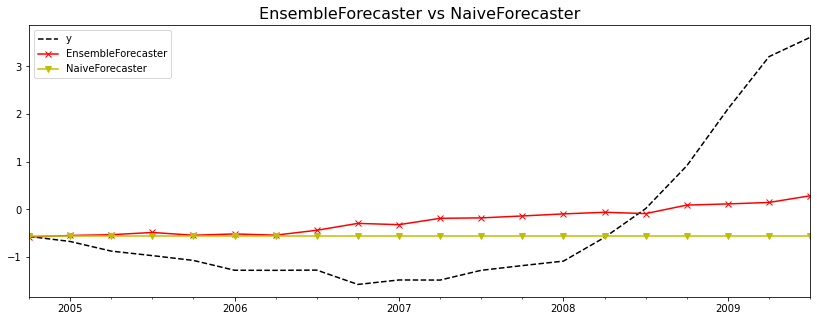

In [454]:
styles = ['k--','rx-','yv-']
for col, s in zip(y_hat, styles):
    y_hat[col].plot(style=s, label=col, 
                    title='EnsembleForecaster vs NaiveForecaster')
plt.legend()
plt.savefig('../../../Packt-Time-Series-Cookbook/Chapters/Ch12/images/fig_12.18.png', bbox_inches='tight', dpi=600)

In [501]:
multi_grid.best_params_

{'selected_forecaster': 'GradientBoosting'}

In [500]:
multi_grid.cv_results_

mean_test_MeanAbsolutePercentageError  mean_fit_time  mean_pred_time  \
0                               0.287071       0.016769        0.006967   
1                               0.108129       0.305849        0.068155   
2                               0.303801       0.015557        0.006060   
3                               0.105496       0.190713        0.007355   

                                              params  \
0        {'selected_forecaster': 'LinearRegression'}   
1            {'selected_forecaster': 'RandomForest'}   
2  {'selected_forecaster': 'SupportVectorRegressor'}   
3        {'selected_forecaster': 'GradientBoosting'}   

   rank_test_MeanAbsolutePercentageError  
0                                    3.0  
1                                    2.0  
2                                    4.0  
3                                    1.0

## There is more

In [455]:
regressors

[('LinearRegression',
  RecursiveTabularRegressionForecaster(estimator=LinearRegression())),
 ('RandomForest',
  RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor())),
 ('SupportVectorRegressor',
  RecursiveTabularRegressionForecaster(estimator=SVR())),
 ('GradientBoosting',
  RecursiveTabularRegressionForecaster(estimator=GradientBoostingRegressor()))]

In [456]:
from sktime.forecasting.compose import AutoEnsembleForecaster

auto = AutoEnsembleForecaster(forecasters=regressors,
                             method='feature-importance')
auto.fit(y=y_train, X=exog_train)

AutoEnsembleForecaster(forecasters=[('LinearRegression',
                                     RecursiveTabularRegressionForecaster(estimator=LinearRegression())),
                                    ('RandomForest',
                                     RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor())),
                                    ('SupportVectorRegressor',
                                     RecursiveTabularRegressionForecaster(estimator=SVR())),
                                    ('GradientBoosting',
                                     RecursiveTabularRegressionForecaster(estimator=GradientBoostingRegressor()))])

In [461]:
auto.weights_

[0.1239225131192647,
 0.2634642533645639,
 0.2731867227890818,
 0.3394265107270897]

In [458]:
y_hat['AutoEnsembleForecaster'] = auto.predict(fh=fh, X=exog_test)

In [460]:
evaluate(y_hat, y_train)

sMAPE      MAPE      RMSE      MASE
EnsembleForecaster      1.211790  1.000520  1.338320  4.454848
NaiveForecaster         0.946033  2.490779  1.537844  4.522654
AutoEnsembleForecaster  1.351585  0.795818  1.423364  4.876082